# **How do types of crime and demographic and economic factors in different community areas influence arrest rates in Chicago?**

# Project 1

## 1.1 Introduction

Crime is a complex and multifaceted issue that has significant implications for public safety and community well-being. In general, Crime could be divided into two types, violent and non-violent crime; furthermore, crimes like "Homicide", "Assault", and "Robbery" are considered violent, while crimes like "Theft" and "Property damage" are non-violent. Ousey (2000) discusses that declining economic status increases poverty rates and population movements like new immigrants, and leads to rising crime rates. This relates to how socioeconomic factors influence arrest rates. The city of Chicago, like many urban centers, experiences a diverse range of criminal activities. Therefore, Chicago has been grappling with crime-related concerns, and understanding the factors influencing arrest rates can offer valuable insights into effective law enforcement strategies and community safety. This dataset reference is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system and hosted in Google BigQuery, which contains incidents of crime except murders that occurred in the city of Chicago from 2001 to 2024. 

Braga et al. (2012) suggest that robbery incidents were highly concentrated in a small number of street units and that these units exhibited different trends over time depending on the type of robbery (street, commercial, or other). Hence, I am wondering whether other types of crime would likely take place in only certain community areas, and what factors cause it. Moreover, Wilson (1987) discusses that disadvantaged communities experience disproportionately high levels of unemployment, inadequate educational opportunities, and limited access to essential resources, which fosters an environment conducive to crime. Therefore, I am going to start with per capita income to observe the relationship between the number of crimes and the arrest rate caused by economic factors.

In addition, racial disparity is a topic that has been concerned and discussed all the time. Despite controlling for various factors, Black young adults are found to be arrested seven times more often than their White counterparts (Schleiden et al., 2020). I will also research race distribution to see how this is relevant to my research question. Erbe (1975) mentions that affluent Black individuals experience less isolation from low-income Black individuals compared to the level of isolation observed among high-income White individuals and low-income White individuals. That might explain why low-income areas are predominantly black. After researching economic factors, I am going to analyze how racial distribution influences arrest rates, and whether these two factors will interplay.

Moreover, I am going to observe whether the arrest rate and crime activities change from year to year, in the meanwhile, more detailed observations make sense, such as whether changes in temperature over the four seasons of the year affect criminal activity and arrest rates. Hou et al. (2023) suggest that high temperatures have a positive effect on increasing urban crime risk. However, it does not mention the relationship between temperature and arrest rates.

Throughout my analysis, I will employ statistical tools, including histograms, box plots, and line charts, to visually represent the relationships between crime types, time, locations, and arrest rates. These visualizations will provide valuable insights into patterns and trends within the dataset. At the end of the project, I will also use OLS regression and machine learning which allow me to go beyond descriptive analysis and uncover more nuanced relationships between variables. 

This project seeks to analyze the relationship between different crime types, demographics and economics of community areas of Chicago and the arrest rate from 2002 to 2023. The type of crime in a given area can significantly affect law enforcement strategies, community safety perceptions, and arrest rates. In addition, factors such as socioeconomic conditions, population density, and community policing strategies may contribute to differences in arrest rates across locations. However, it is essential to acknowledge the limitations inherent in this study, such as potential data constraints and external factors influencing crime dynamics.

Overall, the outcome of this project is arrest rates and there are a total of five basic independent variables, crime types, year, population, race distribution and per capita income. There are 35 crime types in the original dataset and 77 community areas in Chicago. After researching, I find that these independent variables will affect arrest rates to some extent, but per capita income and race distribution in community areas have more impacts.

## 1.2 Data Cleaning and Loading

Before summarising, I need to clean our original dataset first. In this section, I will drop some columns that are useless to my research, such as 'ICUR', 'Domestic', 'Beat', and 'Ward'. Also, there are some incidents that do not keep detailed records, so I need to clean those data to get a more complete dataset, called 'chicago_crime_clean'. To keep the data clean, I change the data of 'District' and 'Community Area' from float to integer.

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point

In [2]:
relative_path = os.path.join('..', 'Data', 'Chicago_Crime.csv')
abs_path = os.path.abspath(relative_path)

# Read the CSV file
chicago_crime = pd.read_csv(abs_path)

In [4]:
chicago_crime.shape

(7983700, 22)

In [5]:
chicago_crime.isnull().any(axis=0)

ID                      False
Case Number             False
Date                    False
Block                   False
IUCR                    False
Primary Type            False
Description             False
Location Description     True
Arrest                  False
Domestic                False
Beat                    False
District                 True
Ward                     True
Community Area           True
FBI Code                False
X Coordinate             True
Y Coordinate             True
Year                    False
Updated On              False
Latitude                 True
Longitude                True
Location                 True
dtype: bool

In this dataset, there are 7983700 rows and 22 columns, for those columns, the community area contains missing data, so I need to drop these data to make accurate observations.

In [3]:
# Drop missing value
chicago_crime_clean = chicago_crime.dropna()
# Drop community area missing value
chicago_crime_clean = chicago_crime_clean[chicago_crime_clean['Community Area'] !=0]
# Drop useless columns
chicago_crime_clean = chicago_crime_clean.drop(['IUCR','Location Description','Domestic','Beat',
                                                'Ward','Block','FBI Code','X Coordinate','Y Coordinate',
                                                'Updated On','Description','District'], axis=1)

After dropping missing values we found that the number of incidents in the years 2001 and 2024 is much less than in other years, especially for the year 2024, there are at most two months' data in the dataset. In this research, I will focus on the annual change in arrest rates. Therefore, I am going to delete these two years.

In [4]:
# Drop years 2001 and 2024
chicago_crime_clean = chicago_crime_clean[(chicago_crime_clean['Year'] != 2001) & (chicago_crime_clean['Year'] != 2024)]
# Change ' Community Area' data into int
chicago_crime_clean['Community Area'] = chicago_crime_clean['Community Area'].astype(int)
# Drop duplicates to keep unique rows
type_mapping = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT', 'NON - CRIMINAL':'NON-CRIMINAL'}
chicago_crime_clean['Primary Type'] = chicago_crime_clean['Primary Type'].replace(type_mapping)
chicago_crime_clean = chicago_crime_clean.drop_duplicates()

In [7]:
chicago_crime_clean.shape

(7268092, 11)

After cleaning data, there are 7,268,092 rows and 11 columns left.

## 1.3 Merging With a New Dataset

Here, I want to merge a dataset, population by community area, to analyze the root cause of the different arrest rates in different community areas better. This dataset is found on Kaggle and contains the population for each community area.

In [5]:
relative_path4 = os.path.join('..', 'Data', 'Chicago_population.csv')
abs_path4 = os.path.abspath(relative_path4)

# Read the CSV file
pop_community_area = pd.read_csv(abs_path4)

In [6]:
pop_community_area_clean = pop_community_area[['Community Area', 'population']]
pop_community_area_clean.isnull().any(axis=0)

Community Area    False
population        False
dtype: bool

In [7]:
pop_merged = pd.merge(chicago_crime_clean, pop_community_area_clean, left_on='Community Area', right_on='Community Area', how='left')

In [38]:
pop_merged['population'].describe()

count    7.268092e+06
mean     4.725302e+04
std      2.453086e+04
min      2.876000e+03
25%      2.965100e+04
50%      4.437700e+04
75%      5.652100e+04
max      9.851400e+04
Name: population, dtype: float64

Above we can see the population situation across 77 community areas. The minimum population is 2876 people and the maximum is 98514 people, and there is a huge difference.

## 1.4 Summary Statistics Tables and Plots

### $X_1$: Crime Types

In [122]:
# Create a pivot table to count the number of 'True' and 'False' in each primary type
crime_arrest = chicago_crime_clean.pivot_table(index='Primary Type', columns='Arrest', aggfunc='size', fill_value=0)
# Rename culumns to clarify
crime_arrest.columns = ['Arrested (False)', 'Arrested (True)']
crime_arrest['Percent_Arrested (True)'] = (crime_arrest['Arrested (True)'] / (crime_arrest['Arrested (False)'] + 
                                                                              crime_arrest['Arrested (True)'])) * 100
crime_arrest = crime_arrest.reset_index()
crime_arrest.describe()

Arrested (False)  Arrested (True)  Percent_Arrested (True)
count      3.300000e+01        33.000000                33.000000
mean       1.640142e+05     56231.030303                41.441135
std        3.246437e+05    125913.303927                36.313729
min        3.000000e+00         2.000000                 5.653641
25%        1.670000e+02       623.000000                11.912738
50%        6.564000e+03     12790.000000                20.752443
75%        2.508970e+05     54229.000000                72.812999
max        1.374957e+06    668226.000000                99.549286

The statistical table above shows that for all of 33 types of crimes, the highest arrest rate is about 99.6%, and the lowest arrest rate is about 5.7%. Also, the average arrest rate is 41.4% approximately, which means more than half of the suspects are not arrested. I will plot graphs to show each primary type's arrest rates later.

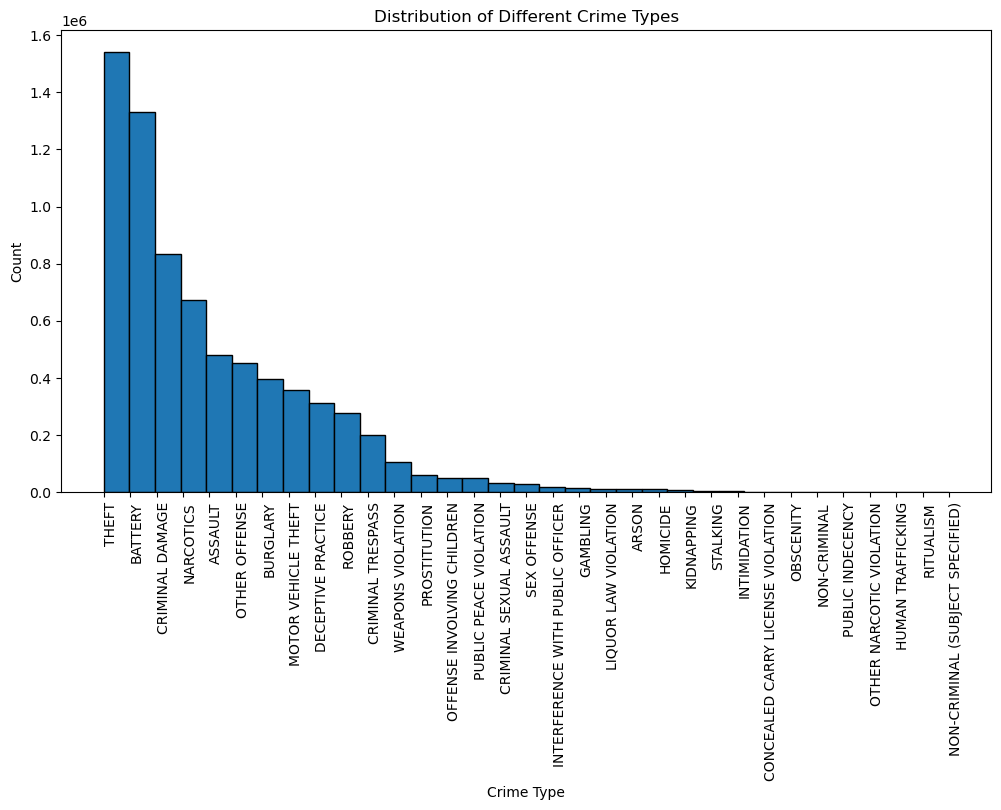

In [114]:
crime_type_counts = chicago_crime_clean['Primary Type'].value_counts()
crime_type_counts_sorted = crime_type_counts.sort_values(ascending = False)
sorted_data = chicago_crime_clean['Primary Type'].map(lambda x: crime_type_counts_sorted.index.get_loc(x))
# Create a histogram
plt.figure(figsize=(12,6))
plt.hist(sorted_data, bins=len(crime_type_counts_sorted), edgecolor='black')
plt.title('Distribution of Different Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='left', ticks=range(len(crime_type_counts_sorted.index)), labels=crime_type_counts_sorted.index)
plt.show()

The histogram is the distribution of crime types' counts, some types having fewer quantities, but I cannot give up any crime types' data since I am going to analyze how crime types influence arrest rates, also these incidents will keep happening in our lives even though the amount that occurs is small. The graph gives us information that the number of crime types of theft and battery is the highest.

In [78]:
crime_arrest.set_index('Primary Type', inplace = True)
print(crime_arrest.loc[crime_arrest['Percent_Arrested (True)'].idxmax()])
print(crime_arrest.loc[crime_arrest['Percent_Arrested (True)'].idxmin()])
print(crime_arrest.describe())

Arrested (False)             277.000000
Arrested (True)            61181.000000
Percent_Arrested (True)       99.549286
Name: PROSTITUTION, dtype: float64
Arrested (False)           373154.000000
Arrested (True)             22361.000000
Percent_Arrested (True)         5.653641
Name: BURGLARY, dtype: float64
       Arrested (False)  Arrested (True)  Percent_Arrested (True)
count      3.300000e+01        33.000000                33.000000
mean       1.640142e+05     56231.030303                41.441135
std        3.246437e+05    125913.303927                36.313729
min        3.000000e+00         2.000000                 5.653641
25%        1.670000e+02       623.000000                11.912738
50%        6.564000e+03     12790.000000                20.752443
75%        2.508970e+05     54229.000000                72.812999
max        1.374957e+06    668226.000000                99.549286


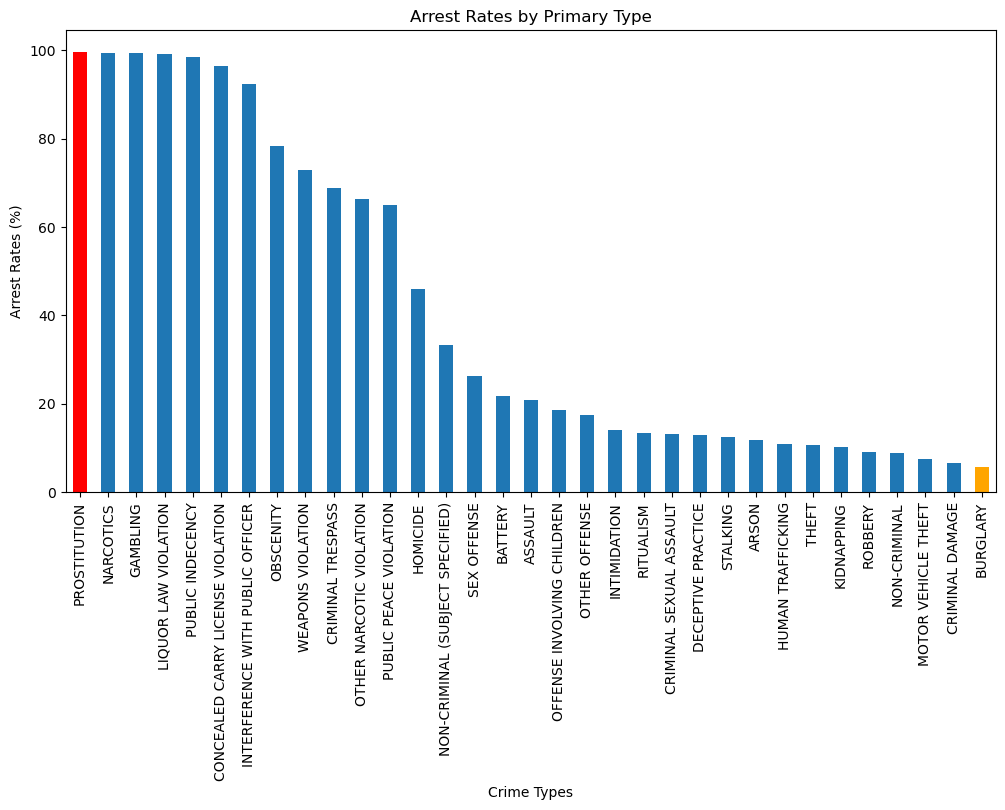

In [79]:
crime_arrest_sorted = crime_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)

ax = crime_arrest_sorted.plot(kind='bar', y='Percent_Arrested (True)', legend=False, figsize=(12, 6))
max_index = crime_arrest_sorted['Percent_Arrested (True)'].idxmax()
min_index = crime_arrest_sorted['Percent_Arrested (True)'].idxmin()
ax.patches[crime_arrest_sorted.index.get_loc(max_index)].set_facecolor('red')
ax.patches[crime_arrest_sorted.index.get_loc(min_index)].set_facecolor('orange')

plt.title('Arrest Rates by Primary Type')
plt.xlabel('Crime Types')
plt.ylabel('Arrest Rates (%)')
plt.xticks(rotation=90)
plt.show()

Now, we can easily see that the crime type of prostitution has the highest arrest rate at about 99.6%, while the type of burglary has the lowest arrest rate at about 5.7%. This bar chart with each crime type on the x-axis and arrest rates on the y-axis, shows that most of the crime types have either high arrest rates greater than 60% or low arrest rates less than 20%. According to the distribution of crime types before, we found that 'theft' and 'battery' are the most frequent occurrences but their arrest rates are not the highest, which describes from the side that it is very difficult to catch this type of criminal. Again, it expresses crime types will influence arrest rates to a certain degree.

### $X_2$: Population Density of Community Areas

In this part, since I have merged a population dataset, I am going to focus on what each community area's population looks like, then show the arrest rate in every area without other factors to see the relationship between the population of the community area and the arrest rates.

In [15]:
pop_merged_area = pop_merged[['Community Area', 'population']]
pop_merged_area_uniq = pop_merged_area.drop_duplicates(['Community Area'])
grouped_population = pop_merged_area_uniq.groupby('Community Area')['population'].sum().reset_index()
grouped_population_sorted = grouped_population.sort_values(by='population', ascending=False)
grouped_population_sorted = grouped_population_sorted.reset_index(drop=True)
grouped_population_sorted.set_index('Community Area', inplace = True)

<Figure size 1500x800 with 0 Axes>

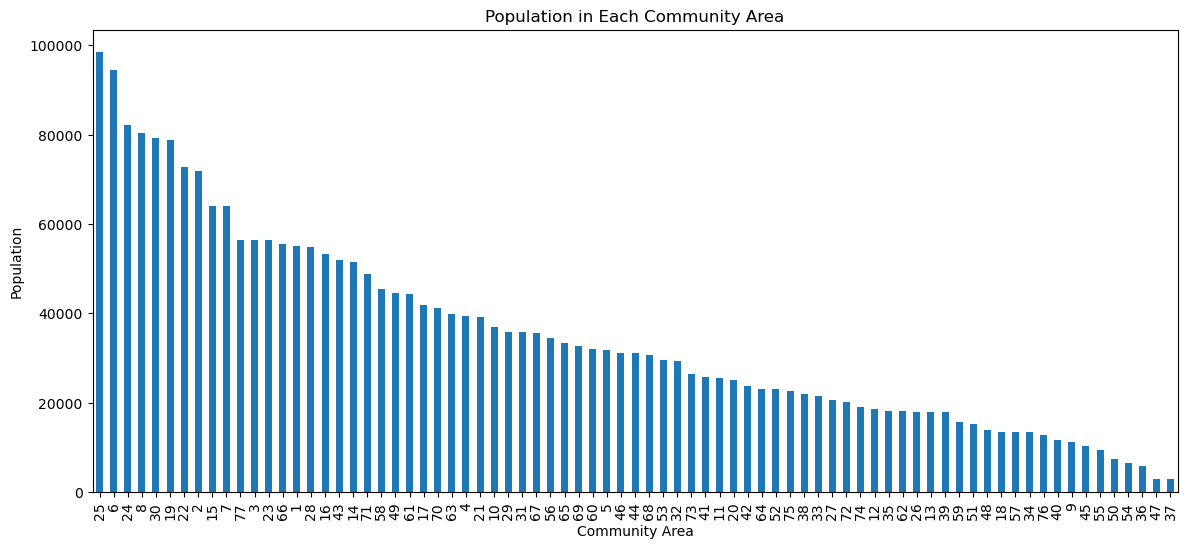

In [112]:
plt.figure(figsize=(15, 8))
ax = grouped_population_sorted.plot(kind='bar', y='population', legend=False, figsize=(14, 6))

plt.title('Population in Each Community Area')
plt.xlabel('Community Area')
plt.ylabel('Population')
plt.show()

This bar plot presents the population in each community area in order. It is obvious that area 25 has the highest population, while area 37 has the lowest. Next, I will plot a graph of arrest rates in each community area to see whether there is a relationship between population density and arrest rates.

In [13]:
# Create a pivot table to count the number of 'True' and 'False' in each community area
area_arrest = chicago_crime_clean.pivot_table(index='Community Area', columns='Arrest', aggfunc='size', fill_value=0)
area_arrest.columns = ['Arrested (False)', 'Arrested (True)']
area_arrest['Percent_Arrested (True)'] = (area_arrest['Arrested (True)'] / (area_arrest['Arrested (False)'] + 
                                                                              area_arrest['Arrested (True)'])) * 100
area_arrest_sorted = area_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)
area_arrest = area_arrest.reset_index()

In [81]:
area_arrest.describe()

Community Area  Arrested (False)  Arrested (True)  \
count       77.000000         77.000000        77.000000   
mean        39.000000      70291.792208     24099.012987   
std         22.371857      54214.181844     25795.026325   
min          1.000000       6387.000000       823.000000   
25%         20.000000      28961.000000      6857.000000   
50%         39.000000      53404.000000     14875.000000   
75%         58.000000      99376.000000     33282.000000   
max         77.000000     284329.000000    168020.000000   

       Percent_Arrested (True)  
count                77.000000  
mean                 22.534966  
std                   6.608262  
min                  10.383647  
25%                  17.701992  
50%                  22.382251  
75%                  25.630492  
max                  42.966774

In [22]:
area_arrest.set_index('Community Area', inplace = True)
print(area_arrest.loc[area_arrest['Percent_Arrested (True)'].idxmax()])
print(area_arrest.loc[area_arrest['Percent_Arrested (True)'].idxmin()])

Arrested (False)           77811.000000
Arrested (True)            58620.000000
Percent_Arrested (True)       42.966774
Name: 26, dtype: float64
Arrested (False)           12100.000000
Arrested (True)             1402.000000
Percent_Arrested (True)       10.383647
Name: 12, dtype: float64


The statistical table above shows arrest rates in all communities. As we can see, the average arrest rate is around 22.53%, and the community area with the lowest arrest rate is about 10.38%, while the highest is about 42.97%. There is still a gap between the two communities.

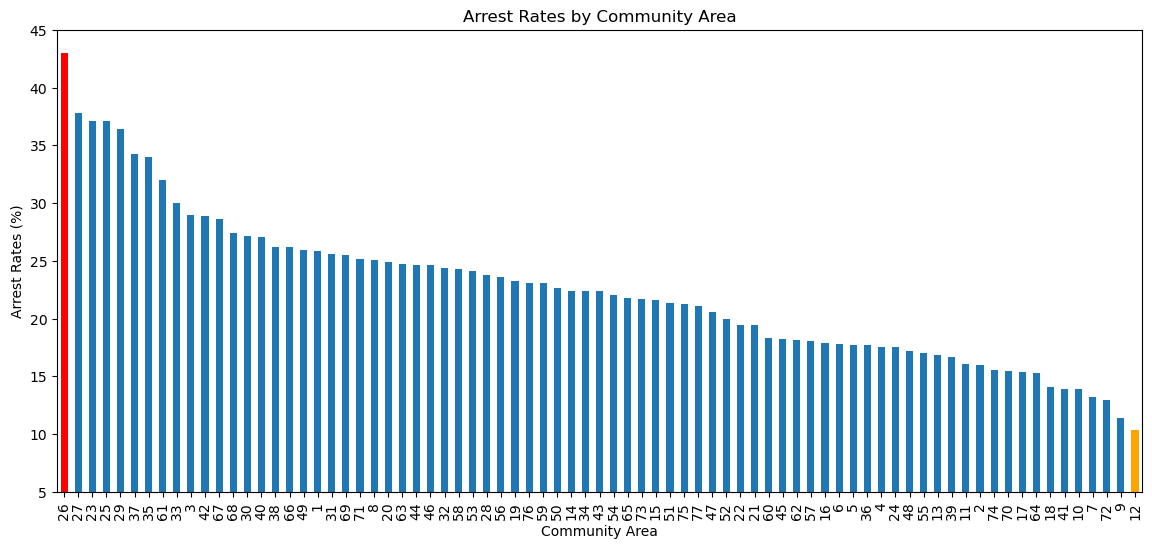

In [83]:
ax2 = area_arrest_sorted.plot(kind='bar', y='Percent_Arrested (True)', legend=False, figsize=(14, 6))
max_index2 = area_arrest_sorted['Percent_Arrested (True)'].idxmax()
min_index2 = area_arrest_sorted['Percent_Arrested (True)'].idxmin()
ax2.patches[area_arrest_sorted.index.get_loc(max_index2)].set_facecolor('red')
ax2.patches[area_arrest_sorted.index.get_loc(min_index2)].set_facecolor('orange')
plt.ylim(5,45)
plt.title('Arrest Rates by Community Area')
plt.xlabel('Community Area')
plt.ylabel('Arrest Rates (%)')
plt.show()

The bar plot above shows each community area with respect to arrest rates. Through observation, we can see that Area 12 has the lowest arrest rate at 10.4%, and Area 26 has the highest arrest rate at 43%. In addition, from the table above, the average arrest rate is about 22.5%, which is less than the arrest rates we have seen before based on the type of crime. We are interested in the root causes of the different arrest rates in different regions, Even though the relationship between population density and arrest rates is not clear, I still need to merge another dataset in future projects, like different regional economies or race distribution to get a deeper understanding.

### $X_3$: Year

In this section, we are going to study changes in arrest rates from year to year.

In [282]:
# Create a pivot table to count the number of 'True' and 'False' in each year
year_arrest = chicago_crime_clean.pivot_table(index='Year', columns='Arrest', aggfunc='size', fill_value=0)
year_arrest.columns = ['Arrested (False)', 'Arrested (True)']
year_arrest['Percent_Arrested (True)'] = (year_arrest['Arrested (True)'] / (year_arrest['Arrested (False)'] + 
                                                                              year_arrest['Arrested (True)'])) * 100
year_arrest_sorted = year_arrest.sort_values(by='Percent_Arrested (True)', ascending=False)
year_arrest = year_arrest.reset_index()

In [85]:
year_arrest.describe()

Year  Arrested (False)  Arrested (True)  Percent_Arrested (True)
count    22.000000         22.000000        22.000000                22.000000
mean   2012.500000     246021.272727     84346.545455                24.214572
std       6.493587      50938.203752     39477.788173                 6.452209
min    2002.000000     173138.000000     25025.000000                11.569934
25%    2007.250000     207865.000000     52870.750000                19.907587
50%    2012.500000     236506.000000     88518.000000                27.097991
75%    2017.750000     297128.750000    108642.250000                28.793249
max    2023.000000     331541.000000    144248.000000                31.170812

Again, this statistical table illustrates the information on arrest rates for years from 2002 to 2023. The average arrest rate is about 24.21%, and the highest arrest rate has reached 31.17%, but the lowest is around 11.57%. Now, I will plot arrest rates for each year in detail.

In [15]:
print(year_arrest.loc[year_arrest['Percent_Arrested (True)'].idxmax()])
print(year_arrest.loc[year_arrest['Percent_Arrested (True)'].idxmin()])

Year                         2005.000000
Arrested (False)           309646.000000
Arrested (True)            140230.000000
Percent_Arrested (True)        31.170812
Name: 3, dtype: float64
Year                         2022.000000
Arrested (False)           207166.000000
Arrested (True)             27105.000000
Percent_Arrested (True)        11.569934
Name: 20, dtype: float64


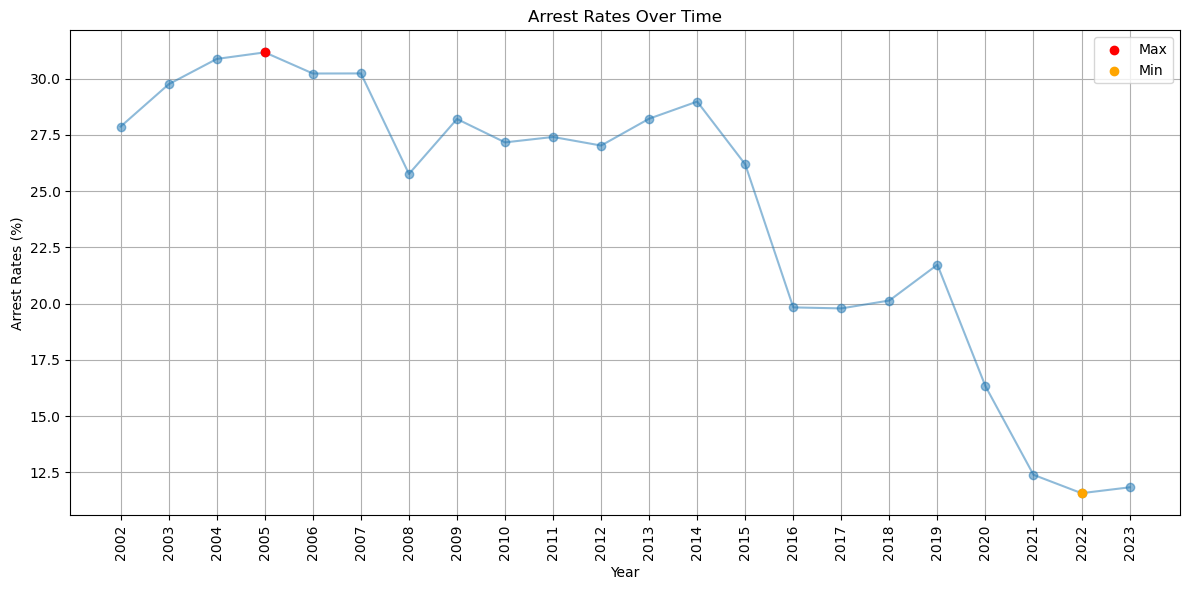

In [283]:
plt.figure(figsize=(12, 6))
plt.plot(year_arrest['Year'], year_arrest['Percent_Arrested (True)'], marker='o', linestyle='-', alpha=0.5, zorder=2)

max_index = year_arrest['Percent_Arrested (True)'].idxmax()
min_index = year_arrest['Percent_Arrested (True)'].idxmin()
plt.scatter(year_arrest['Year'][max_index], year_arrest['Percent_Arrested (True)'][max_index], 
            color='red', label='Max', zorder=3)
plt.scatter(year_arrest['Year'][min_index], year_arrest['Percent_Arrested (True)'][min_index], 
            color='orange', label='Min', zorder=3)

plt.title('Arrest Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Arrest Rates (%)')
plt.grid(True)
plt.xticks(year_arrest['Year'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

The line chart above illustrates the arrest rates from 2002 to 2023. The maximum arrest rate was in 2005, which is 31.2%, and the minimum arrest rate was in 2022 at 11.6%. Moreover, we could see that there is a corner in 2008, and we might guess that is due to the 2008 recession but need more evidence. There are two sharp declines, one was in 2014, and another was in 2019. We should do more research to explain the phenomenon. Also, the statistics summary mentions the average arrest rate is about 24.2%.

### Combine Independent Variables

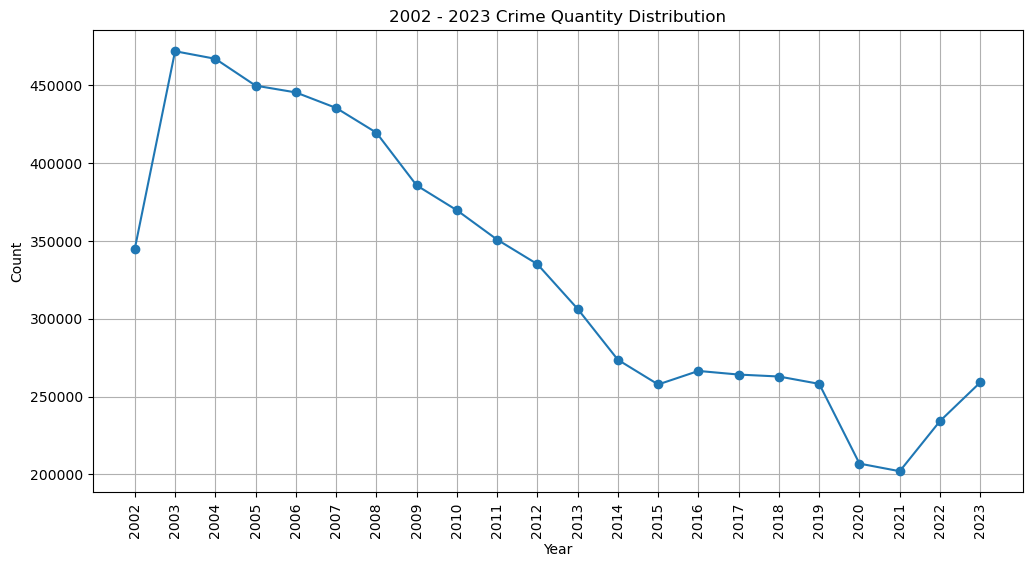

In [13]:
year_counts = chicago_crime_clean['Year'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-')
plt.title('2002 - 2023 Crime Quantity Distribution')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(year_counts.index, rotation=90)
plt.grid(True)
plt.show()

The line chart above shows the variation in crime quantity from 2002 to 2023. It gives us a surprising result since the number of crimes peaked in 2003 and then continued to decline, reaching its lowest in 2021. We can see that the quantity changes are quite different with the arrest rates changing over time, so we want to explore how each primary type and community area influences arrest rates in each year.

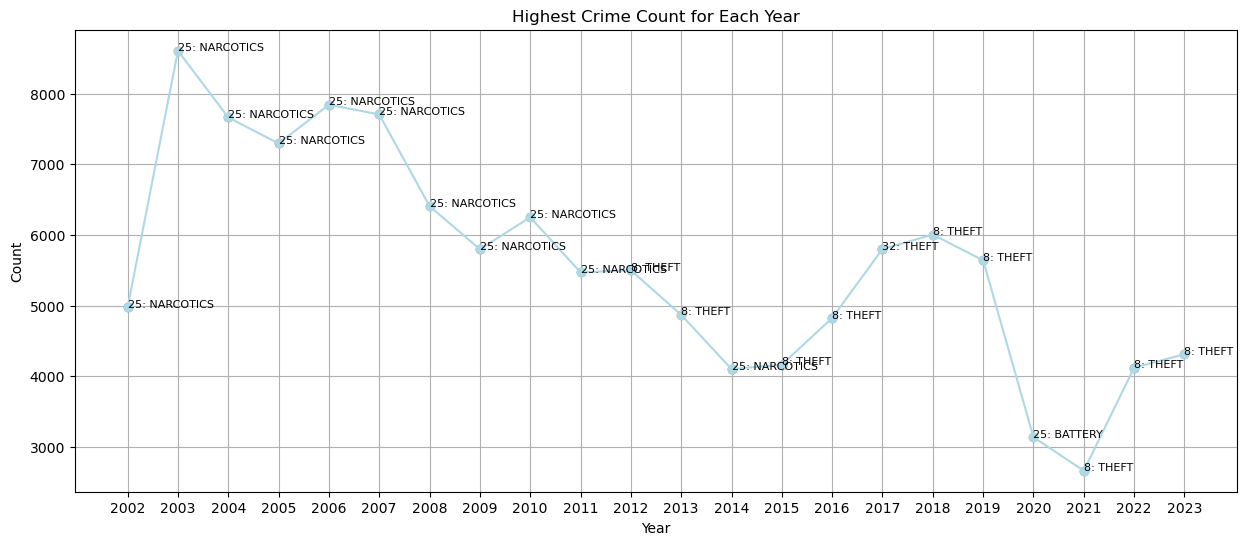

In [31]:
combine = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).size().reset_index(name='Count')
# Sort the DataFrame by Year and count
combine_sorted = combine.sort_values(by=['Year', 'Count'], ascending=[True, False])
new = combine_sorted.groupby('Year').head(1)

# Plot the graph
plt.figure(figsize=(15, 6))
for idx, row in new.iterrows():
    plt.scatter(row['Year'], row['Count'], label=f"{row['Community Area']}: {row['Primary Type']}")
    plt.text(row['Year'], row['Count'], f"{row['Community Area']}: {row['Primary Type']}", fontsize=8)

plt.plot(new['Year'], new['Count'], marker='o', linestyle='-', color='lightblue')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Highest Crime Count for Each Year')
plt.xticks(new['Year'])
plt.grid(True)
plt.show()

The graph above shows the highest crime count for each year, and each point mentions its community area and crime type. Different from the previous parts, I would like to combine three independent variables and observe the correlation between them and the arrest rate. Through observation, I found that among all the highest crime counts, in the year 2003, the crime type of narcotics in community area 25 is the highest; and theft in community area 8 of year 2021 is the lowest. Moreover, before 2014, the highest number of crimes per year is mostly in community area 25 and the narcotics category, while after 2014, they focus on community area 8 and theft primary type. The results are totally different from what I found before using a single variable. Therefore, I would guess that the combination of these variables will influence the arrest rate over time.

In [14]:
most_frequent_type_idx = combine.groupby('Community Area')['Count'].idxmax()
# Create a DataFrame with the most frequent 'Primary Type' for each 'Community Area'
most_frequent_types = combine.loc[most_frequent_type_idx][['Community Area', 'Primary Type', 'Count']]
# Count the number of areas where each crime type occurs the most
area_counts = most_frequent_types.groupby('Primary Type').size().reset_index(name='Area Count')
print(area_counts)

worst_frequent_type_idx = combine.groupby('Community Area')['Count'].idxmin()
# Create a DataFrame with the worst frequent 'Primary Type' for each 'Community Area'
worst_frequent_types = combine.loc[worst_frequent_type_idx][['Community Area', 'Primary Type', 'Count']]
# Count the number of areas where each crime type occurs the worst
area_counts2 = worst_frequent_types.groupby('Primary Type').size().reset_index(name='Area Count')
print(area_counts2)

        Primary Type  Area Count
0            BATTERY          23
1    CRIMINAL DAMAGE           7
2  CRIMINAL TRESPASS           1
3          NARCOTICS           7
4              THEFT          39
                        Primary Type  Area Count
0                              ARSON          51
1  CONCEALED CARRY LICENSE VIOLATION          23
2                           GAMBLING           2
3                           HOMICIDE           1


Here, it represents 5 types of crime that occur the most in each area of Chicago and 4 types of crime that occur the least from 2002 to 2023. We know that in 77 community areas, theft is the most common crime in these areas, which happened the most frequently in 39 areas. Battery is the second-highest crime type in 23 out of 77 areas. On the contrary, there are 51 areas where arson occurs the least in all of the crime types.

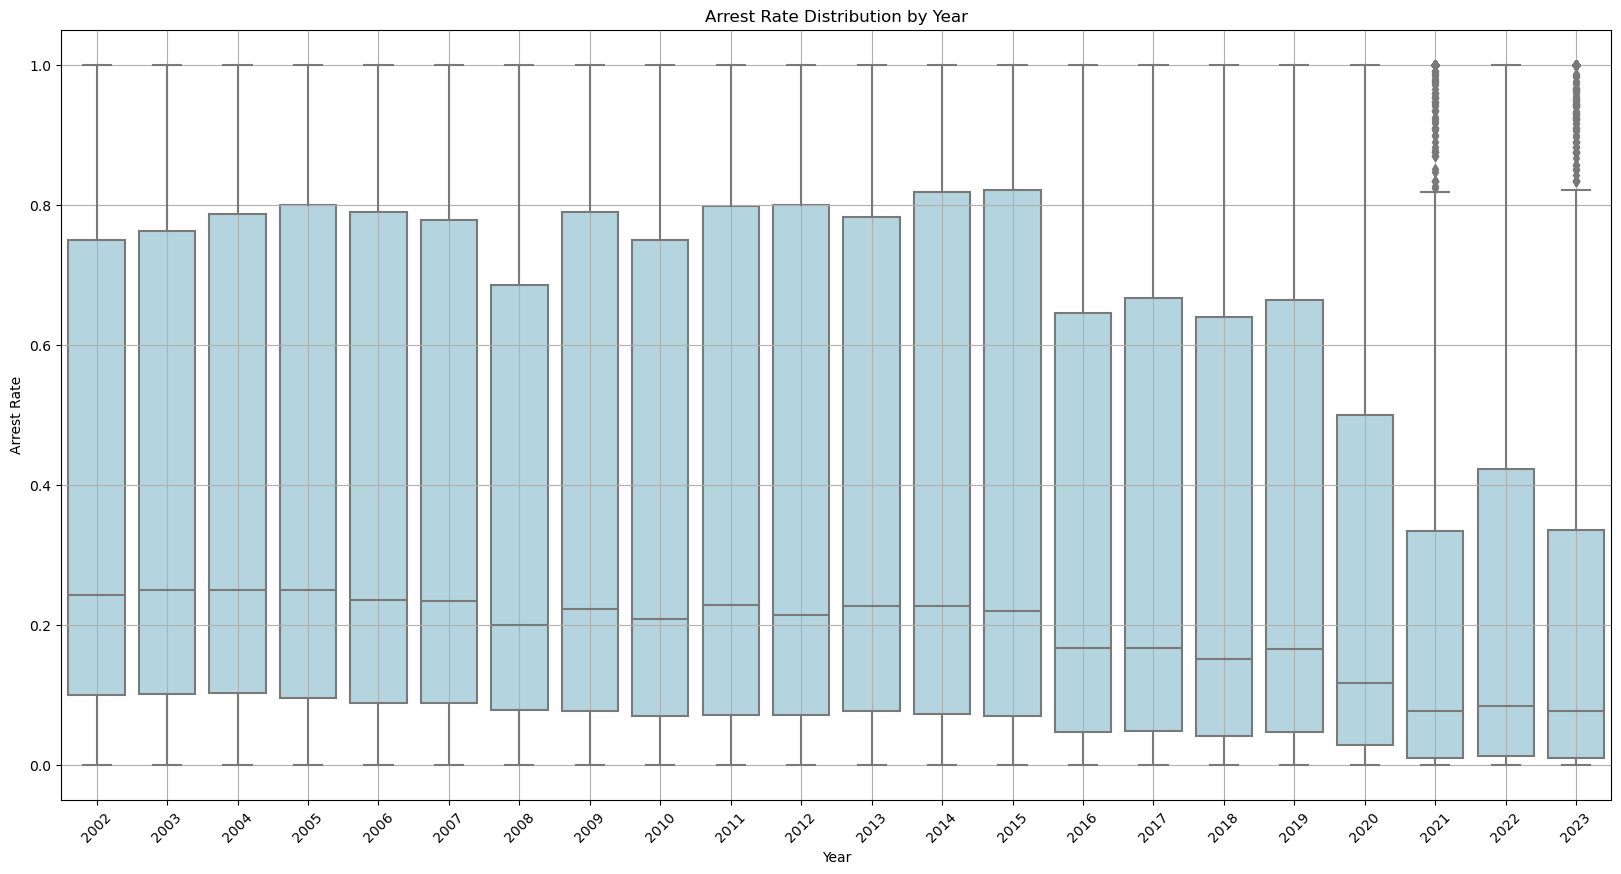

In [50]:
combine_new = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).agg({'Arrest':['mean']}).reset_index()
plt.figure(figsize=(20, 10))
sns.boxplot(data=combine_new, x='Year', y=('Arrest', 'mean'), color='lightblue')
plt.title('Arrest Rate Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Arrest Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This boxplot of arrest rate distribution is different from the plot of arrest rate over time before. In the last graph, I only consider one variable which is years, but in this boxplot, I combine all three variables, community areas, crime types, and years, so it actually shows the distribution of arrest rates based on primary types and each area for every year. As we can see, in the years 2021 and 2023, their arrest rates are concentrated below 40%, and so arrest rates higher than 81% become outliers. The boxplot considers the interplay between crime types and demographic factors to influence the arrest rates.

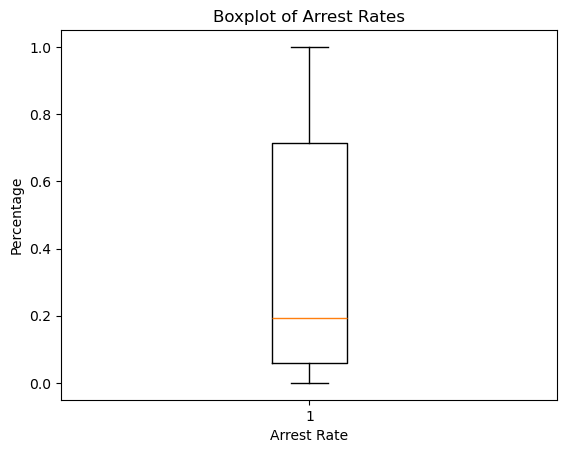

Arrest
               mean
count  40268.000000
mean       0.364232
std        0.374328
min        0.000000
25%        0.059829
50%        0.193025
75%        0.714286
max        1.000000

In [53]:
combine_new = chicago_crime_clean.groupby(['Community Area', 'Primary Type', 'Year']).agg({'Arrest':['mean']})

# Create a boxplot for arrest rates
plt.boxplot(combine_new)
plt.title('Boxplot of Arrest Rates')
plt.xlabel('Arrest Rate')
plt.ylabel('Percentage')
plt.show()
combine_new.describe()

The boxplot of arrest rates represents the arrest rates based on 33 crime types, 77 community areas, and whole years. We can see that its min is 0% and max is 100%, also its average is around 36.4%, but the median rate is only around 19.3% and is a right-skewed plot. According to the box plot, the 25th percentile of the arrest rate is around 6% and the 75th percentile is around 71.4%, which is a huge difference.

# Project 2

## 2.1 The Message

Different population sizes in communities lead to differences in the number of crimes and crime rates, which in turn affect the arrest rate.

In [33]:
crime_counts = chicago_crime_clean['Community Area'].value_counts()
pop_by_area = pop_merged.set_index('Community Area')['population']
crime_rates = (crime_counts / 22) / pop_by_area *100
crime_rates = crime_rates.drop_duplicates()
pop_area_crime = area_arrest.merge(grouped_population, on='Community Area')

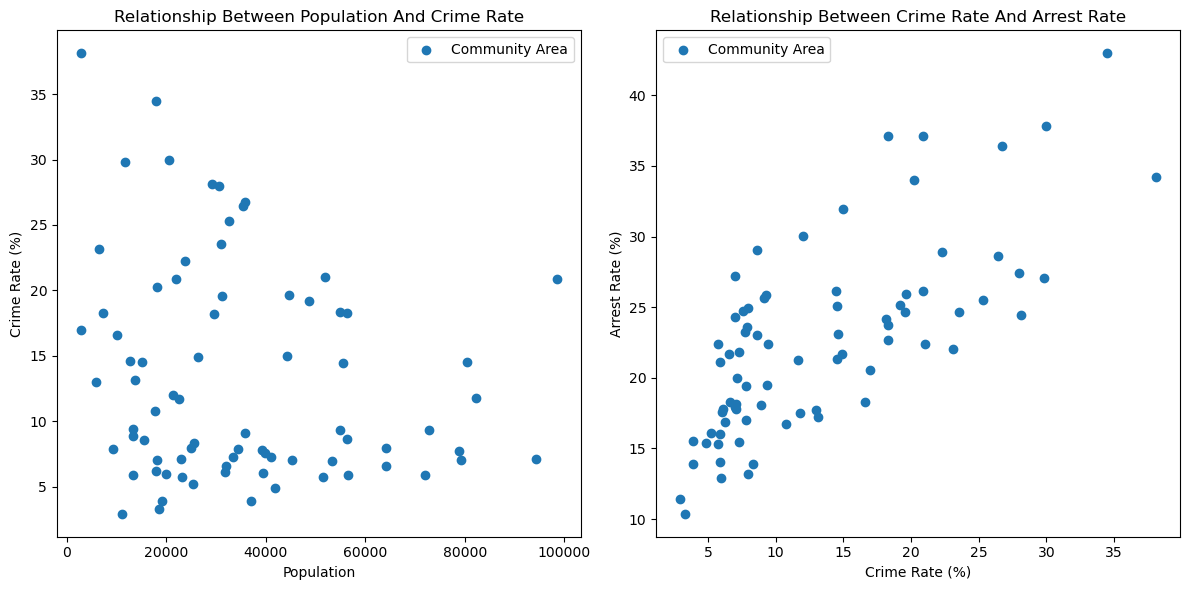

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of Population vs Crime Rate
axs[0].scatter(pop_area_crime['population'], crime_rates.values, label='Community Area')
axs[0].set_xlabel('Population')
axs[0].set_ylabel('Crime Rate (%)')
axs[0].set_title('Relationship Between Population And Crime Rate')

# Scatter plot of Crime Rate vs Arrest Rate
axs[1].scatter(crime_rates.values, pop_area_crime['Percent_Arrested (True)'], label='Community Area')
axs[1].set_xlabel('Crime Rate (%)')
axs[1].set_ylabel('Arrest Rate (%)')
axs[1].set_title('Relationship Between Crime Rate And Arrest Rate')

axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

The scatter plot above shows the relationship between population and crime rate, as well as the relationship between crime rate and arrest rate for each community area. In the first subplot, it looks like an inverse function, which means as the population increases, the crime rate decreases. Also, in the second subplot, the correlation does not look like a linear function. It seems like a logarithmic function, which means an increase in crime will lead to an increase in arrests but has a diminished effect..

## 2.2 Maps and Interpretations

### Merging with a New Dataset

The new dataset I have chosen is per capita income in Chicago starting from 2006 to 2022 and divided into four periods, which is from the American Community Survey and collected by the Chicago Health Atlas, and this dataset is statistically classified by community name. It provides a crucial socio-economic dimension to my analysis of crime trends in Chicago. By merging this new dataset, I can observe how per capita income levels have evolved and potentially impacted various aspects of community life, including crime rates and law enforcement responses so that research how fluctuations in per capita income may intersect with crime trends across Chicago's diverse communities and then affect arrest rates. I call this new dataset 'per_capita_income', and I will also clean this data by dropping missing values. In the end, I am going to combine the new dataset into 'chicago_crime_clean' based on community area and call it 'merge'.

In [102]:
relative_path2 = os.path.join('..', 'Data', 'per_capita_income.csv')
abs_path2 = os.path.abspath(relative_path2)

# Read the CSV file
per_capita_income = pd.read_csv(abs_path2)

In [218]:
per_capita_income.isnull().any(axis=0)

Layer             True
Name              True
GEOID             True
Longitude         True
Latitude          True
PCI_2018-2022    False
PCI_2014-2018    False
PCI_2010-2014    False
PCI_2006-2010    False
dtype: bool

In [221]:
per_capita_income.dtypes

Layer             object
Name              object
GEOID            float64
Longitude        float64
Latitude         float64
PCI_2018-2022     object
PCI_2014-2018     object
PCI_2010-2014     object
PCI_2006-2010     object
dtype: object

In [103]:
per_capita_income = per_capita_income.dropna()
per_capita_income = per_capita_income.drop(['Longitude','Latitude','Layer'],axis=1)
per_capita_income['GEOID'] = per_capita_income['GEOID'].astype(int)
per_capita_income['PCI_2006-2010'] = per_capita_income['PCI_2006-2010'].astype(float)
per_capita_income['PCI_2010-2014'] = per_capita_income['PCI_2010-2014'].astype(float)
per_capita_income['PCI_2014-2018'] = per_capita_income['PCI_2014-2018'].astype(float)
per_capita_income['PCI_2018-2022'] = per_capita_income['PCI_2018-2022'].astype(float)

In [104]:
merge = pd.merge(chicago_crime_clean, per_capita_income, left_on='Community Area', right_on='GEOID', how='left')

In [105]:
merge['Per Capita Income'] = (merge['PCI_2018-2022'] + merge['PCI_2014-2018'] +
                              merge['PCI_2010-2014'] + merge['PCI_2006-2010'])/4
merge = merge.drop(['GEOID','Date','PCI_2018-2022','PCI_2010-2014','PCI_2014-2018','PCI_2006-2010'],axis=1)

### Maps

In [106]:
merge['Location'] = list(zip(merge.Longitude, merge.Latitude))
merge['Location'] = merge['Location'].apply(Point)

In [19]:
shapefile_path = os.path.join('..', 'Data', 'Boundaries - Community Areas (current).zip')
chicago_shape = gpd.read_file(shapefile_path)

In [23]:
chicago_shape['area_numbe'] = chicago_shape['area_numbe'].astype('int32')
merged_df = chicago_shape.merge(area_arrest, left_on="area_numbe", right_on='Community Area')

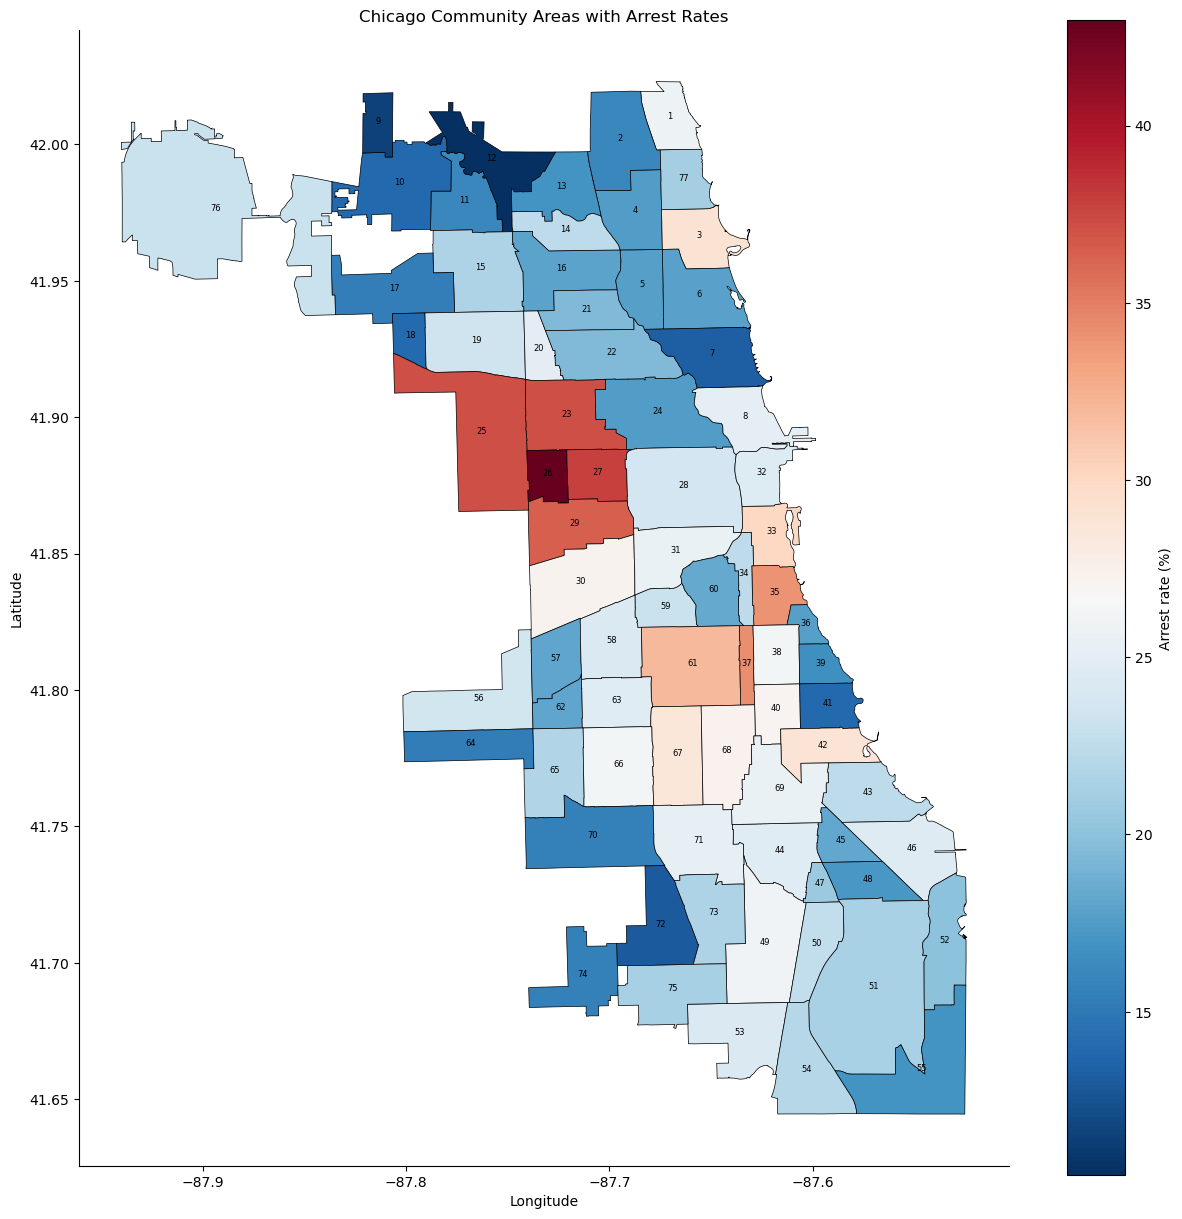

In [73]:
fig, gax = plt.subplots(figsize=(15, 15))

merged_df.plot(ax=gax, column='Percent_Arrested (True)', cmap='RdBu_r', legend=True,
               legend_kwds={'label': 'Arrest rate (%)'}, edgecolor='black', linewidth=0.5)

for idx, row in merged_df.iterrows():
    gax.annotate(text=str(row['area_numbe']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6)
plt.title('Chicago Community Areas with Arrest Rates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

The map above shows the arrest rates in 77 community areas in Chicago. As we can see, West Garfield Park (area 26) has the highest arrest rate, and Forest Glen (area 12) has the lowest arrest rate. It is worth noting that a couple of areas around West Garfield Park also have high arrest rates. Also, most of the north side of Chicago have lower arrest rates. The map as a whole is in light blue, the same as when we analyzed the relationship between community areas and arrest rates separately, the average is around 22.5%. Later, I will create a map that present relationship between crime quantity with community areas.

In [60]:
crime_area_counts = chicago_crime_clean['Community Area'].value_counts()
crime_pop_merged = pd.merge(crime_area_counts, pop_community_area_clean, left_index=True, right_on='Community Area')
crime_pop_merged['crime_per_100k'] = (crime_pop_merged['count'] / crime_pop_merged['population']) * 100000

merged_df2 = chicago_shape.merge(crime_pop_merged, left_on="area_numbe", right_on='Community Area')

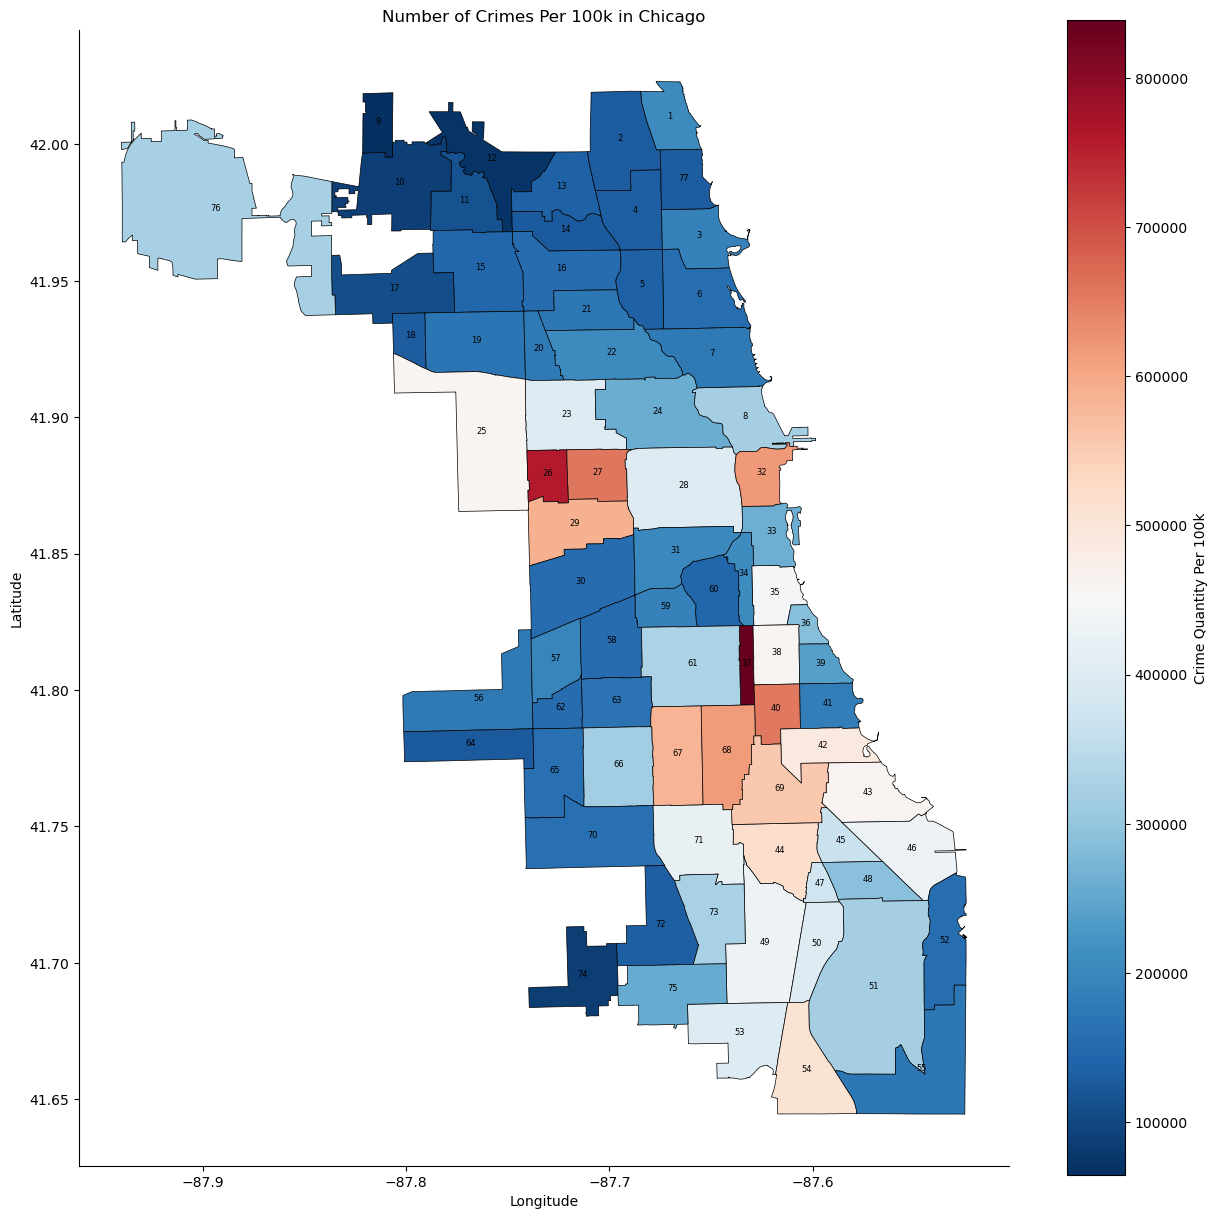

In [62]:
fig, gax = plt.subplots(figsize=(15, 15))

merged_df2.plot(ax=gax, column='crime_per_100k', cmap='RdBu_r', legend=True,
               legend_kwds={'label': 'Crime Quantity Per 100k'}, edgecolor='black', linewidth=0.5)

for idx, row in merged_df2.iterrows():
    gax.annotate(text=str(row['area_numbe']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                horizontalalignment='center', fontsize=6)
plt.title('Number of Crimes Per 100k in Chicago')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In analyzing the distribution of crime per 100k population across Chicago's community areas, I observe notable disparities, particularly in areas such as Fuller Park (area 37) and West Garfield Park (area 26), which exhibit a high number of crimes compared to others. This finding underscores the multifaceted interplay between crime types, demographic characteristics, and law enforcement practices as outlined in the research question. Moreover, this examination reveals intriguing variations in arrest rates across different areas. Compared to the previous map, despite areas like 23 and 25 not having much higher crime counts, their arrest rates are still high. This underscores the complexity of factors influencing law enforcement outcomes within distinct community contexts, warranting further investigation into the nuanced dynamics between crime occurrence, arrest practices, and community characteristics.


In [45]:
primary_types = chicago_crime_clean['Primary Type'].unique()
violent_crimes = ['ASSAULT', 'WEAPONS VIOLATION', 'HOMICIDE', 'SEX OFFENSE', 'ROBBERY', 
                  'CRIMINAL SEXUAL ASSAULT', 'KIDNAPPING']

# Categorize primary types into violent and non-violent crimes
violent_types = [pt for pt in primary_types if pt in violent_crimes]
non_violent_types = [pt for pt in primary_types if pt not in violent_crimes]

violent_data = chicago_crime_clean[chicago_crime_clean['Primary Type'].isin(violent_types)]
non_violent_data = chicago_crime_clean[chicago_crime_clean['Primary Type'].isin(non_violent_types)]

In [52]:
violent_data_counts = violent_data['Community Area'].value_counts()
non_violent_data_counts = non_violent_data['Community Area'].value_counts()
vio_pop_merged = pd.merge(violent_data_counts, pop_community_area_clean, left_index=True, right_on='Community Area')
nonvio_pop_merged = pd.merge(non_violent_data_counts, pop_community_area_clean, left_index=True, right_on='Community Area')
vio_pop_merged['vio_crime_per_100k'] = (vio_pop_merged['count'] / vio_pop_merged['population']) * 100000
nonvio_pop_merged['nonvio_crime_per_100k'] = (nonvio_pop_merged['count'] / nonvio_pop_merged['population']) * 100000

merged_df3 = chicago_shape.merge(vio_pop_merged, left_on="area_numbe", right_on='Community Area')
merged_df4 = chicago_shape.merge(nonvio_pop_merged, left_on="area_numbe", right_on='Community Area')

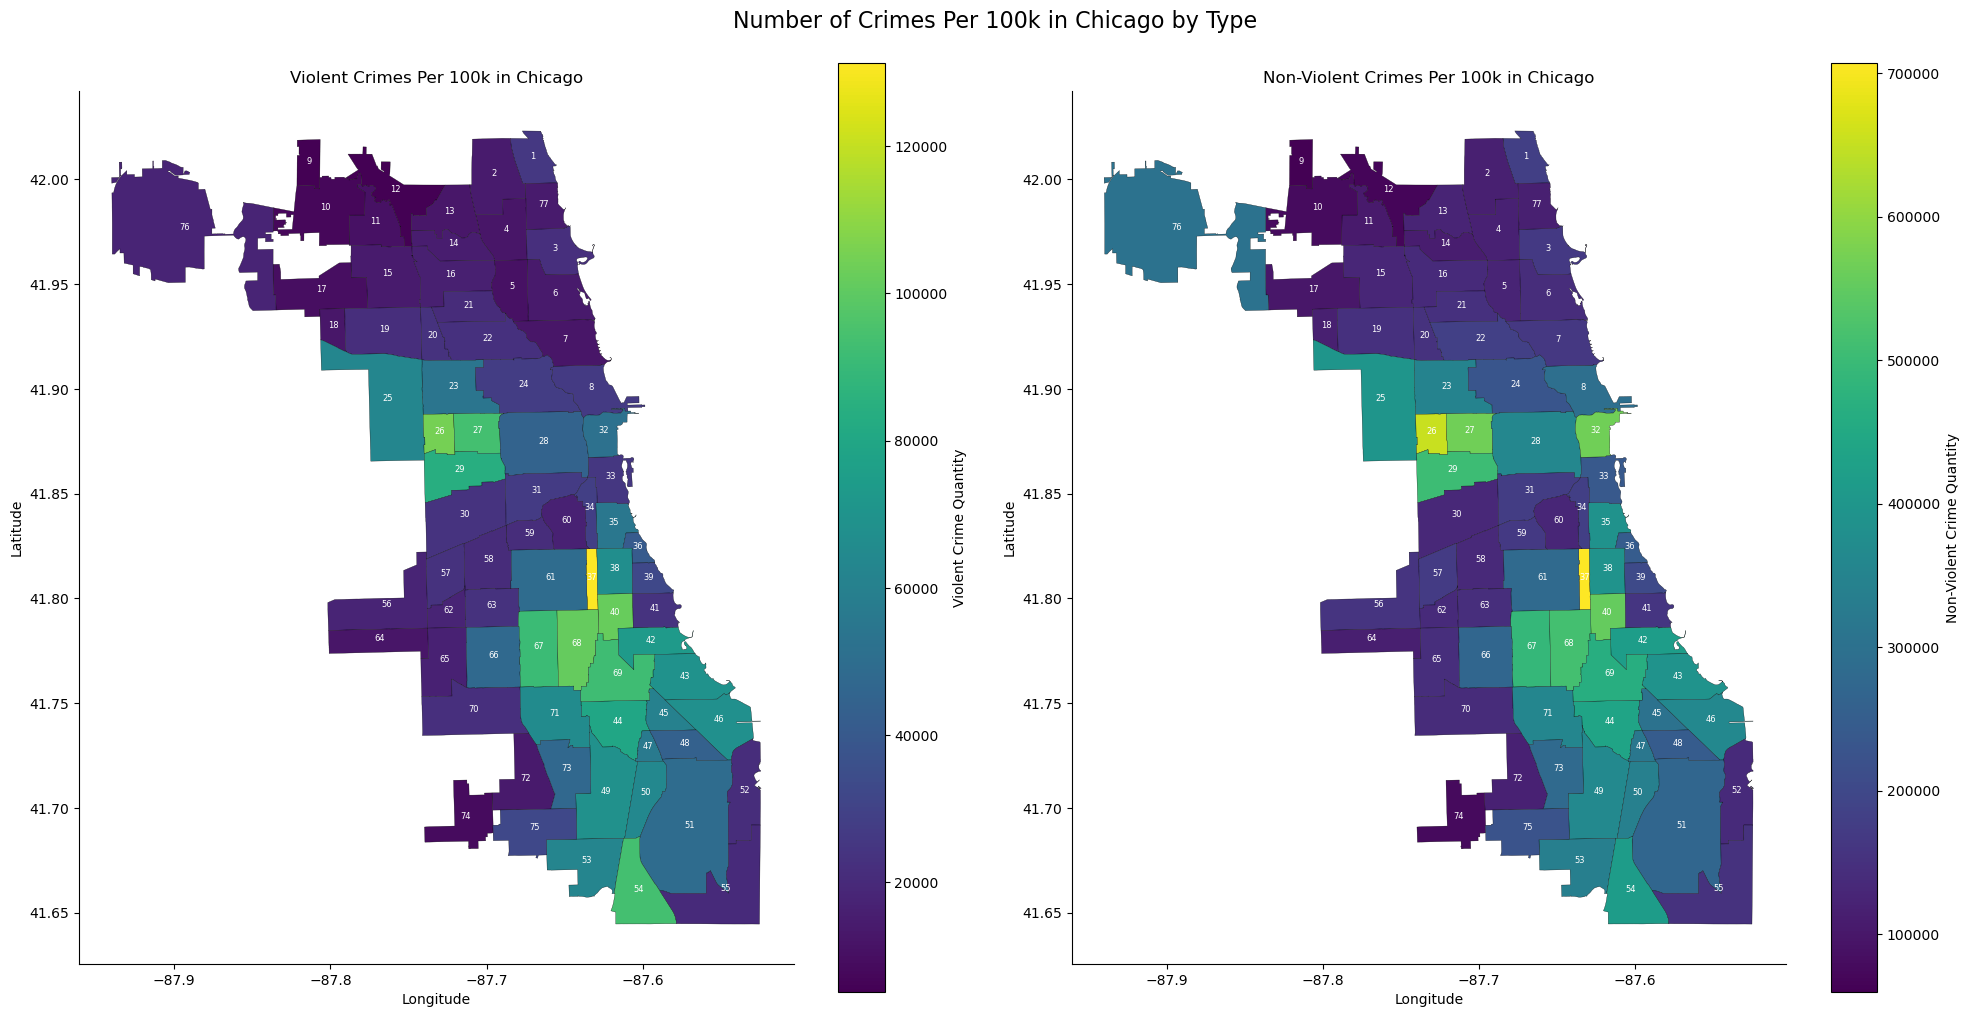

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
merged_df3.plot(ax=axes[0], column='vio_crime_per_100k', legend=True, legend_kwds={'label': 'Violent Crime Quantity'},
               edgecolor='black', linewidth=0.2)
axes[0].set_title('Violent Crimes Per 100k in Chicago')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
for idx, row in merged_df3.iterrows():
    axes[0].annotate(text=row['area_numbe'], color='white',xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center', fontsize=6)

merged_df4.plot(ax=axes[1], column='nonvio_crime_per_100k', legend=True, legend_kwds={'label': 'Non-Violent Crime Quantity'},
               edgecolor='black', linewidth=0.2)
axes[1].set_title('Non-Violent Crimes Per 100k in Chicago')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
for idx, row in merged_df4.iterrows():
    axes[1].annotate(text=row['area_numbe'], color='white', xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center', fontsize=6)

plt.suptitle('Number of Crimes Per 100k in Chicago by Type', fontsize=16, x=0.5, y=1)
plt.tight_layout()
plt.show()

Now, I separate crime types into two groups, violent and non-violent, to see if the number of violent and nonviolent crimes per 100k in each area does not differ much
. It is clear to see hw othese two groups of crime types are distributed in each community area by map. According to he ttwo maps,the distribution of the two types is roughly the same in 77 areas, but the non-violent crimes quantity is greater than violent crimes overall, however, some areas are still different, O'Hare (area 76) and West Garfield Park (area 26) have proportionally more nonviolent crimes. In general,oIesupposee that non-violent crime is the main factor affecting the arrestrate..

In [239]:
merge_con1 = merge.groupby('Community Area')['Per Capita Income'].mean()

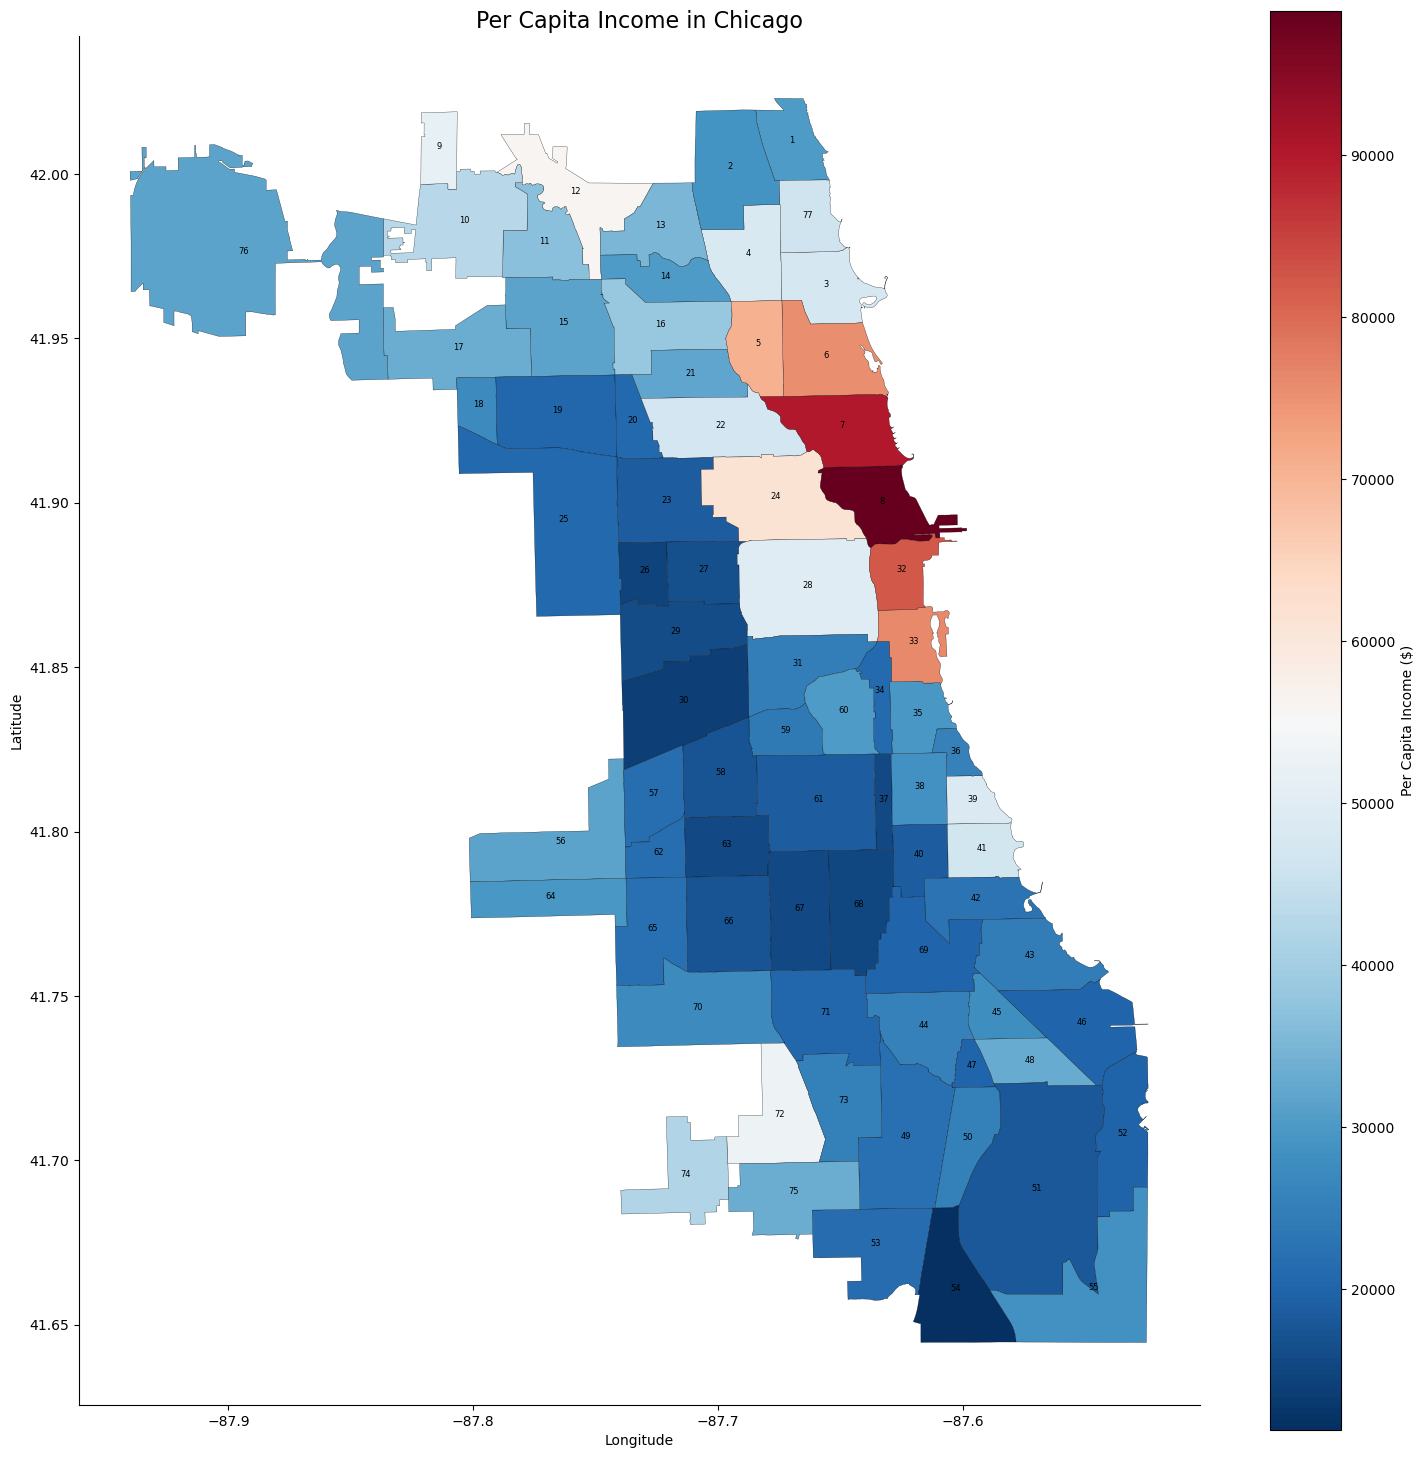

In [240]:
merged_df5 = chicago_shape.merge(merge_con1, left_on="area_numbe", right_on='Community Area')

fig, gax = plt.subplots(figsize=(15, 15))
merged_df5.plot(ax=gax, column='Per Capita Income', cmap='RdBu_r', legend=True, 
                   legend_kwds={'label': 'Per Capita Income ($)'}, edgecolor='black', linewidth=0.2)

for idx, row in merged_df5.iterrows():
    gax.annotate(text=str(row['area_numbe']), xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    horizontalalignment='center', fontsize=6)

plt.title('Per Capita Income in Chicago', fontsize=16, x=0.5, y=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

The map above presents the per capita income in Chicago. As we can see, Near North Side (area 8) has the highest per capita income for all periods, and Loop (area 32) also has a relatively high per capita income. But when we look back, area 32 has a high number of crimes but not a high arrest rate. This data might be used to explain why Loop (area 32) happens this phenomenon, but I still need to find more information about it, like police resources and race distribution. Overall, the per capita income of each community area in Chicago is increasing year by year, but the gap between rich and poor areas is still growing because some areas are growing faster and some less. If we divide Chicago into two groups, per capita income in the Northeast as a whole would be slightly higher than elsewhere. In addition, it seems like areas with lower per capita incomes have higher rates of crime.

# Project 3

## 3.1 Potential Data to Scrape

To enhance the research on the influence of crime types on arrest rates in various areas of Chicago, acquiring data on criminal population demographics by community areas would provide valuable insights. By obtaining a criminal population survey, I can gather information on the demographic characteristics of individuals involved in criminal activities within specific neighbourhoods.

The Chicago Police website (https://publicsearch1.chicagopolice.org/Arrests) serves as a potential source for such data, offering a comprehensive list of crime types for adult arrest records. This dataset includes details such as the individual's name, current age, arrest date, and district of arrest.

By merging this new dataset with existing data on arrest rates, crime quantities, and per capita income in each community area, I can explore potential correlations between demographic factors and crime outcomes. For instance, analyzing whether certain types of crimes are more commonly committed by males or females could shed light on gender disparities in criminal behaviour and law enforcement outcomes. Additionally, investigating whether arrest rates vary based on demographic characteristics such as age or socioeconomic status can provide insights into disparities in policing practices across different community areas.

## 3.2 Potential Challenges

There are several challenges when scraping the website. 

1. The first challenge revolves around the frequency of data updates on the website. It is unclear whether the website updates its crime data daily, monthly, quarterly, or annually. This uncertainty necessitates regular checks over time to ensure that the data used for analysis is current and accurate.

2. Another challenge is the variability in crime types and their corresponding naming conventions on the website. The names of crimes listed may differ from those used in my research project, requiring meticulous identification and mapping of each crime type. Additionally, websites with multiple filters and dynamic content often have complex HTML structures, making it challenging to accurately locate and extract the required data. This complexity adds to the time and effort required for scraping, as each crime type must be individually identified and scraped to ensure comprehensive data collection.

3. Some crucial data, such as gender distribution or crime rates in specific districts need clicking on the "Details" button, leading to additional pages with relevant information. Navigating through these pages and extracting the desired data adds another layer of complexity to the web scraping process.

4. It looks like the website only records data before 2014, however, I want to research the years between 2002 to 2023. The lack of historical data beyond a certain point restricts the scope of my analysis and may introduce biases or gaps in the findings. Hence, it might not so perfect for me to use in this project.

After trying to scrape the website that I want to use, it is difficult beyond imagination. Firstly, I found that it does not show the community area, instead, it shows districts and beats, which are not the category I want. Also, there are a lot of pages of data, which means I am going to have to click on a page again and scrape them.

Overall, the complexity of navigating web scraping, coupled with the inherent limitations of available data sets, presents huge challenges in obtaining the information necessary to effectively achieve research objectives.

## 3.3 Scraping Data from a Website

In this part, I will scrape the average temperature from 2010 to 2019 of Chicago from the Current Results website (https://www.currentresults.com/Weather/Illinois/Places/chicago-temperatures-by-month-average.php). In this part, I am going to see whether temperature causes changes in the types of crimes with the highest numbers in different months, or whether they increase or decrease together since one of my research questions is about how crime types influence arrest rates. And this observation could tell me if I need to control this to my variables.

In [47]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [67]:
web_url = 'https://www.currentresults.com/Weather/Illinois/Places/chicago-temperatures-by-month-average.php'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

response = requests.get(web_url, headers=headers)

First of all, I need to define the URL of the website I want to scrape, and then the headers contain information about the user agent, which helps to identify the browser making the request. In this case, it simulates a request made by the Chrome browser on a Windows system. Lastly in this part, I need to request the URL.

In [68]:
soup_object = BeautifulSoup(response.content)

# Find all tables with the specified class
data_table = soup_object.find_all('table', "articletable tablecol-3-left revcolr")[0]
all_values = data_table.find_all('tr') # Prints the captured tag elements

Here, the BeautifulSoup is a library for parsing HTML documents, which allows me to extract data from HTML. Then, I will find the relevant tags to extract data. In this case, "table" is a tag and "articletable tablecol-3-left revcolr" is a class, the [0] at the end retrieves the first table found with this class name. In the end, I extract all these rows of values into a list by finding the 'tr' values from data_table.

In [69]:
temperature_avg = pd.DataFrame(columns = ['High_F', 'Low_F', 'Month', 'High_C', 'Low_C'])
ix = 0

# Iterate over each table
for row in all_values[1:13]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    High_F = values[0].text
    Low_F = values[1].text
    Month = values[2].text
    High_C = values[3].text
    Low_C = values[4].text
    
    temperature_avg.loc[ix] = [High_F, Low_F, Month, High_C, Low_C]
    ix += 1

I create an empty DataFrame with specified column names: 'High_F', 'Low_F', 'Month', 'High_C', and 'Low_C'. This data frame will eventually store the temperature data. In the for loop, I start from the second row and end with the 12th row, since the last row is the average temperature for the years, find all elements with the 'td' tag within the current row, and then extract the text content of each cell respectively. Lastly, assign the extracted values to the data frame "temperature_avg" at the current index.

In [103]:
temperature_avg.to_csv('Chicago_10years_temperature_avg.csv', index=False)

The data frame can be sorted as a csv file now, called "Chicago_10years_temperature_avg".

## 3.4 Visualizing the Scraped Dataset

In [38]:
temp_avg = pd.read_csv('Chicago_10years_temperature_avg.csv')

In [40]:
# Only keep the month
chicago_crime_clean['Month'] = pd.to_datetime(chicago_crime['Date']).dt.month

month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
               9: 'September', 10: 'October', 11: 'November', 12: 'December'}
month_chicago = chicago_crime_clean
month_chicago['Month'] = month_chicago['Month'].map(month_names)

In [65]:
crime_month = month_chicago.groupby(['Month', 'Primary Type']).size().reset_index(name='Count')

# Find the crime type with the highest count for each month
idx = crime_month.groupby('Month')['Count'].idxmax()
most_frequent_crime_by_month = crime_month.loc[idx]
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
most_frequent_crime_by_month['Month'] = pd.Categorical(most_frequent_crime_by_month['Month'], categories=month_order, ordered=True)
most_frequent_crime_by_month = most_frequent_crime_by_month.sort_values(by='Month')
most_frequent_crime_by_month.reset_index(drop=True, inplace=True)

In [66]:
most_frequent_crime_by_month['Primary Type']

0     THEFT
1     THEFT
2     THEFT
3     THEFT
4     THEFT
5     THEFT
6     THEFT
7     THEFT
8     THEFT
9     THEFT
10    THEFT
11    THEFT
Name: Primary Type, dtype: object

Here is a new table called "most_frequent_crime_by_month" which groups by month, and we can see that no matter in which month, the crime type of the highest number is the same, which is theft. But we still need to plot how the quantity of this incident changes each month with different temperatures.

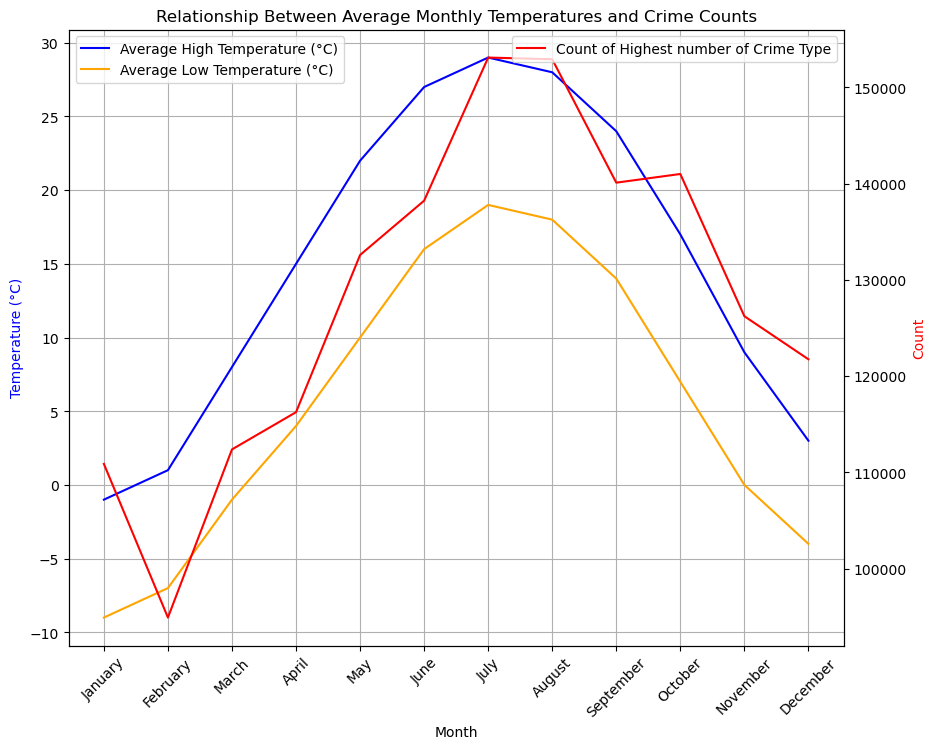

In [161]:
fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot average high temperature
ax1.plot(temp_avg['Month'], temp_avg['High_C'], label='Average High Temperature (°C)', color='blue')
ax1.plot(temp_avg['Month'], temp_avg['Low_C'], label='Average Low Temperature (°C)', color='orange')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature (°C)', color='blue')

ax2 = ax1.twinx()
# Plot crime count
ax2.plot(most_frequent_crime_by_month['Month'], most_frequent_crime_by_month['Count'], label='Count of Highest number of Crime Type', color='red')
ax2.set_ylabel('Count', color='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xticks(range(0, 12))
ax1.set_xticklabels(most_frequent_crime_by_month['Month'], rotation=45)
plt.title('Relationship Between Average Monthly Temperatures and Crime Counts')
ax1.grid(True)

plt.show()

The graph above illustrates the average temperatures observed across the months from 2010 to 2019, also with the counts of theft of reported crimes spanning from 2002 to 2023, categorized by months. A notable observation is the apparent correlation between temperature fluctuations and the frequency of reported crimes. Throughout the analyzed period, it is discernible that theft occurrences peak during the warmer months, with July exhibiting the highest incidence, while February consistently records the lowest. Furthermore, the graph indicates a general trend of rising theft counts as temperatures ascend, which suggests that warmer weather tends to coincide with increased outdoor activities and greater social interaction. However, although the number of monthly incidents varies, the highest monthly number of all crime types has always been theft. Hence, we can ignore the effect of temperature in this project. 

In [89]:
arrest_rate = chicago_crime_clean.pivot_table(index='Month', columns='Arrest', aggfunc='size', fill_value=0)
arrest_rate.columns = ['Arrested (False)', 'Arrested (True)']
arrest_rate['Arrest_Rate (%)'] = (arrest_rate['Arrested (True)'] / (arrest_rate['Arrested (False)'] + 
                                                                              arrest_rate['Arrested (True)'])) * 100
arrest_rate = arrest_rate.reindex(month_order)
arrest_rate = arrest_rate.reset_index()

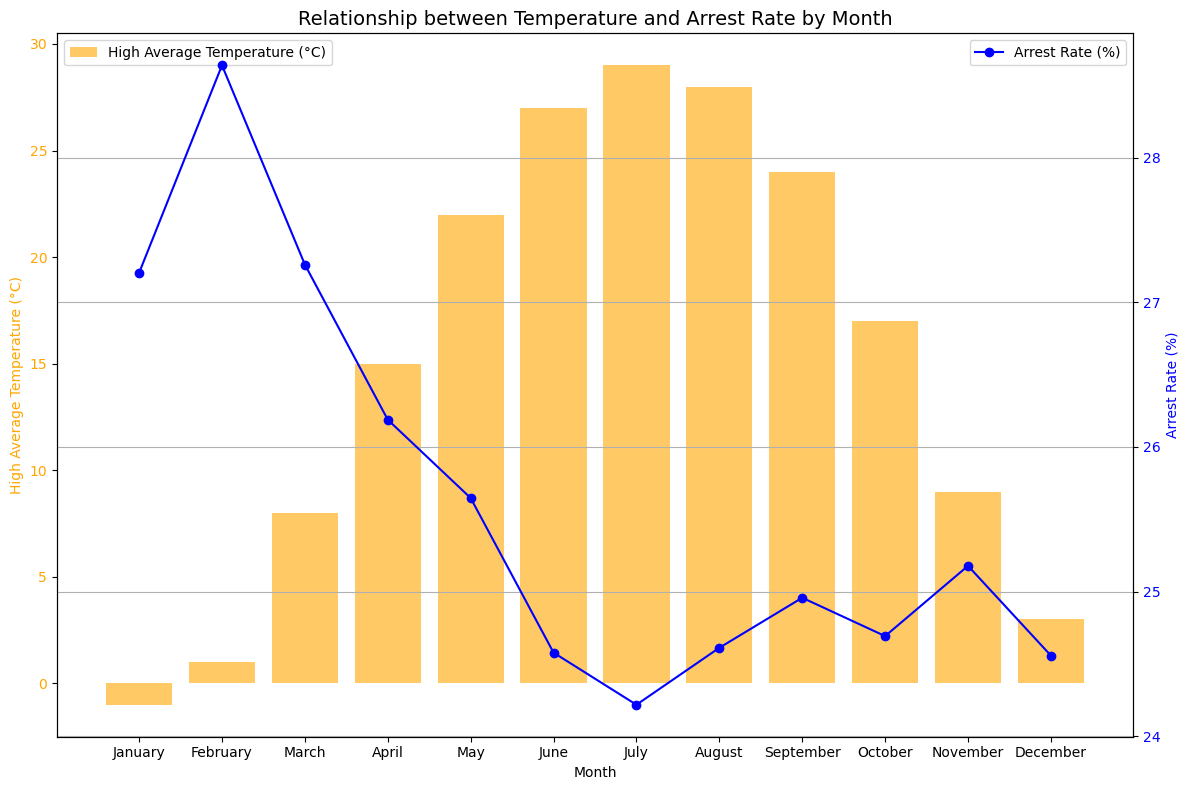

In [92]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting high average temperature as bars
ax1.bar(temp_avg['Month'], temp_avg['High_C'], color='orange', alpha=0.6, label='High Average Temperature (°C)')

ax1.set_xlabel('Month')
ax1.set_ylabel('High Average Temperature (°C)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.legend(loc='upper left')

# Creating a secondary y-axis for arrest rate using a line plot
ax2 = ax1.twinx()
ax2.plot(temp_avg['Month'], arrest_rate['Arrest_Rate (%)'], color='blue', linestyle='-', marker='o', label='Arrest Rate (%)')

ax2.set_ylabel('Arrest Rate (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

plt.title('Relationship between Temperature and Arrest Rate by Month', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot above illustrates the relationship between high average temperatures and the arrest rate. Interestingly, despite the observation that temperature has an impact on crime counts, it appears that the month itself plays a more influential role in determining the arrest rate. In February, despite relatively lower temperatures, the arrest rate surpasses 28%, whereas in July, despite higher temperatures, the arrest rate is only around 24%. Also, according to the bars and line plot, there is a negative correlation between arrest rate and temperature. As temperatures rise, arrest rates decline, and vice versa. This suggests that while hot weather may lead to an increase in the number of crimes, the decrease in arrest rates may be due to the influence of other factors, such as community policing measures. Overall, while the temperature may play a role in shaping criminal behaviour, its impact on arrest rates appears to be mediated by multifaceted socio-economic and institutional factors. Also, the temperature does not affect other variables directly and is not so important, so I will not control the month in future work.

## 3.5 Adding a New Dataset

In this section, I am going to enrich the analysis by integrating a new dataset that provides insights into the racial composition of each community area in Chicago. We know that Chicago is a diverse city and there are many different races in the city, such as Black, White, Asian, and Latino. The sensitive subject here is that crime and arrest rates may differ by race, but I think it is worth researching in this project.

The dataset, sourced from the American Community Survey and obtained via the Chicago Health Atlas website, which offers a comprehensive view of racial distribution across the city's community areas. By incorporating variables such as Non-Hispanic White, Non-Hispanic Black, Asian, Hispanic or Latino, Native American, Pacific Islander/Native Hawaiian, and Two or more races, we gain a nuanced understanding of the diverse population landscape within Chicago.

This integration is essential as it allows us to explore potential correlations between race and crime-related variables. While acknowledging the sensitivity of this subject, it is imperative to investigate whether disparities exist in crime rates and arrest outcomes across different racial groups. By examining these relationships, we can uncover underlying socioeconomic factors.

In [93]:
relative_path3 = os.path.join('..', 'Data', 'Chicago_race.csv')
abs_path3 = os.path.abspath(relative_path3)

# Read the CSV file
chicago_race = pd.read_csv(abs_path3)

In [94]:
chicago_race_clean = chicago_race.rename(columns={"PCT-W_2018-2022": "Non-Hispanic White (%)",
                                                  "PCT-B_2018-2022": "Non-Hispanic Black (%)",
                                                  "PCT-A_2018-2022": "Asian (%)", "PCT-H_2018-2022": "Hispanic or Latino (%)",
                                                  "PCT-P_2018-2022": "Native American (%)", "PCT-P1_2018-2022": "Native Hawaiian (%)",
                                                  "PCT-Q_2018-2022": "Two or more races (%)"})
chicago_race_clean.isnull().any(axis=0)

Layer                      True
Name                       True
GEOID                      True
Population                 True
Longitude                  True
Latitude                   True
Non-Hispanic White (%)    False
Non-Hispanic Black (%)    False
Asian (%)                 False
Hispanic or Latino (%)    False
Native American (%)       False
Native Hawaiian (%)       False
Two or more races (%)     False
dtype: bool

In [95]:
chicago_race_clean = chicago_race_clean.dropna()
chicago_race_clean.dtypes

Layer                      object
Name                       object
GEOID                     float64
Population                float64
Longitude                 float64
Latitude                  float64
Non-Hispanic White (%)     object
Non-Hispanic Black (%)     object
Asian (%)                  object
Hispanic or Latino (%)     object
Native American (%)        object
Native Hawaiian (%)        object
Two or more races (%)      object
dtype: object

In [96]:
# Change data type
chicago_race_clean['GEOID'] = chicago_race_clean['GEOID'].astype(int)
chicago_race_clean['Non-Hispanic White (%)'] = chicago_race_clean['Non-Hispanic White (%)'].astype(float)
chicago_race_clean['Non-Hispanic Black (%)'] = chicago_race_clean['Non-Hispanic Black (%)'].astype(float)
chicago_race_clean['Asian (%)'] = chicago_race_clean['Asian (%)'].astype(float)
chicago_race_clean['Hispanic or Latino (%)'] = chicago_race_clean['Hispanic or Latino (%)'].astype(float)
chicago_race_clean['Native American (%)'] = chicago_race_clean['Native American (%)'].astype(float)
chicago_race_clean['Native Hawaiian (%)'] = chicago_race_clean['Native Hawaiian (%)'].astype(float)
chicago_race_clean['Two or more races (%)'] = chicago_race_clean['Two or more races (%)'].astype(float)
# Combine the last three columns into one column
chicago_race_clean['Other Races (%)'] = chicago_race_clean.apply(lambda row: row['Native American (%)'] + 
                                                                 row['Native Hawaiian (%)'] + row['Two or more races (%)'], axis=1)
# Drop useless columns
chicago_race_clean = chicago_race_clean.drop(['Layer', 'Name', 'Native American (%)', 'Native Hawaiian (%)', 
                                              'Two or more races (%)'], axis=1)
# Keep three decimal
chicago_race_clean['Non-Hispanic White (%)'] = chicago_race_clean['Non-Hispanic White (%)'].round(3)
chicago_race_clean['Non-Hispanic Black (%)'] = chicago_race_clean['Non-Hispanic Black (%)'].round(3)
chicago_race_clean['Asian (%)'] = chicago_race_clean['Asian (%)'].round(3)
chicago_race_clean['Hispanic or Latino (%)'] = chicago_race_clean['Hispanic or Latino (%)'].round(3)
chicago_race_clean['Other Races (%)'] = chicago_race_clean['Other Races (%)'].round(3)

# Drop useless columns
chicago_race_clean = chicago_race_clean.drop(['Longitude', 'Latitude'], axis=1)

In [146]:
chicago_race_clean.describe()

GEOID     Population  Non-Hispanic White (%)  \
count  77.000000      77.000000               77.000000   
mean   39.000000   35570.857143               27.319208   
std    22.371857   23354.909949               25.775990   
min     1.000000    2514.000000                0.239000   
25%    20.000000   18633.000000                4.253000   
50%    39.000000   29899.000000               14.676000   
75%    58.000000   45141.000000               46.676000   
max    77.000000  103048.000000               83.973000   

       Non-Hispanic Black (%)  Asian (%)  Hispanic or Latino (%)  \
count               77.000000  77.000000               77.000000   
mean                36.457883   6.469766               26.964701   
std                 37.990966  10.318573               27.318641   
min                  0.035000   0.000000                0.519000   
25%                  3.368000   0.560000                5.255000   
50%                 13.929000   2.377000               14.835000   
75%                 79.322000   9.274000               46.021000   
max                 96.248000  64.643000               92.191000   

       Other Races (%)  
count        77.000000  
mean          2.402714  
std           1.465437  
min           0.084000  
25%           1.215000  
50%           2.152000  
75%           3.518000  
max           5.900000

The table above shows statistical data about the new dataset. As we can see, in whole community areas of Chicago, the Black population is the largest since its mean is around 36.5%. Also, the average population of whites and Latinos is about the same, with 27.3% and 27% respectively. However, no matter which race, it seems like there exists one area where there is almost all people of that race and another area where there is almost no people of that race by looking for the max and min in the table.

In the next step, I will merge the data and plot some graphs to get a clear and deep observation.

In [139]:
chicago_race_clean_sorted = chicago_race_clean.sort_values(by='Non-Hispanic White (%)', ascending=False)
chicago_race_clean_sorted = chicago_race_clean_sorted.drop(['Population'],axis=1)
chicago_race_clean_sorted.set_index('GEOID', inplace=True)

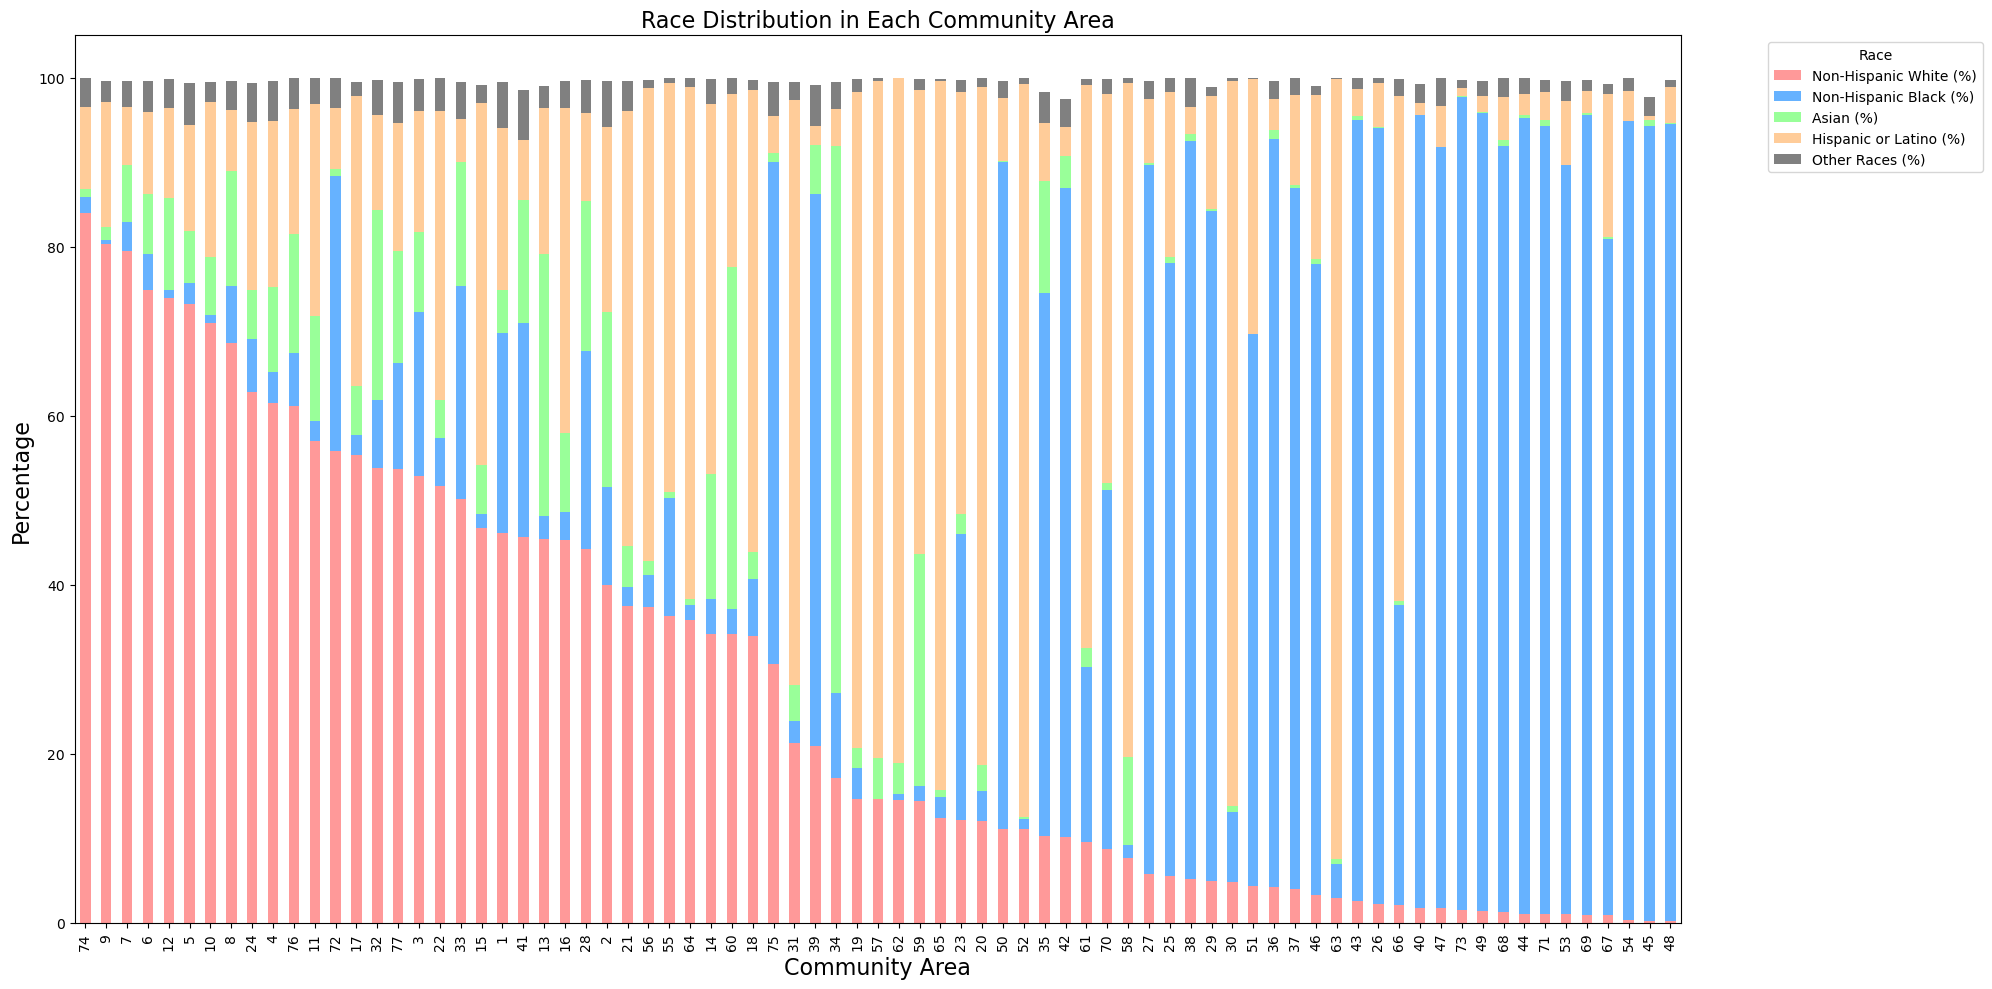

In [141]:
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', 'grey']
chicago_race_clean_sorted.plot(kind='bar', stacked=True, color=colors, figsize=(20,10))

plt.xlabel('Community Area', fontsize=16)
plt.ylabel('Percentage', fontsize=16)
plt.title('Race Distribution in Each Community Area', fontsize=16, x=0.5, y=1)
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(chicago_race_clean_sorted.index)), chicago_race_clean_sorted.index)
plt.tight_layout()
plt.show()

Based on the bar plot, we found that whites, blacks and Latinos are the three main races that make up Chicago, some areas are more Asian, like area 34 and area 60. Now, we could combine this graph and previous maps to see whether there exists some correlation between race and crime counts and arrest rates. Firstly, when looking at the "arrest rates" map, areas 26, 27, 25, 23, 29, 35, and 37 have relatively high arrest rates, and the above graph shows that these areas are predominantly black, except area 23, which has more Latinos. In addition, the map of the number of crimes in Chicago illustrates areas 26, 8, 43, and Central South have higher crime counts. After looking at this plot, we get a result that those areas are rarely predominantly white. Moreover, there is some correlation between per capita income and race proportion in one area. The areas that have higher per capita income are mostly white, and areas that have lower per capita income are mostly black, some are Latino.

Hence, taking these graphs together, we can indeed show that there is a relationship between the racial proportion of an area and the number of crimes, economy, and arrest rates. I will show arrest rates and the relationship between races to get a better understanding later.

In [152]:
crime_race_merge = pd.merge(merge, chicago_race_clean, left_on='Community Area', right_on='GEOID', how='left')
crime_race_merge = crime_race_merge.drop(['GEOID'],axis=1)
crime_race_merge = pd.merge(crime_race_merge, area_arrest, on='Community Area')
crime_race_merge['Non-White (%)'] = crime_race_merge.apply(lambda row: row['Non-Hispanic Black (%)'] + 
                                                             row['Asian (%)'] + row['Hispanic or Latino (%)'] + 
                                                             row['Other Races (%)'], axis=1)

In [156]:
crime_race_merge = crime_race_merge.drop_duplicates(['Community Area'])

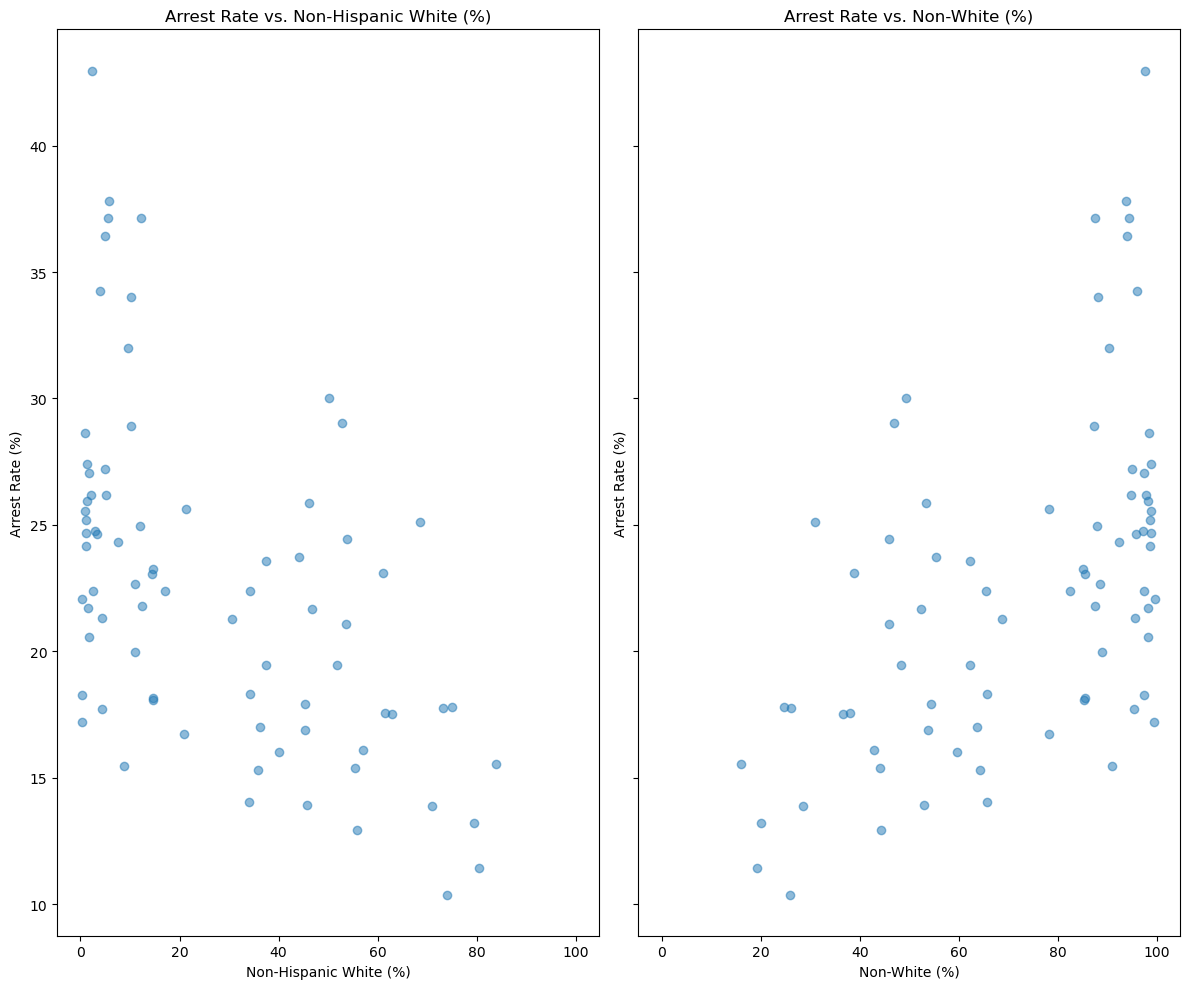

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), sharex=True, sharey=True)
race_columns = ['Non-Hispanic White (%)', 'Non-White (%)']

for i, race in enumerate(race_columns):
    ax = axes[i]
    ax.scatter(crime_race_merge[race], crime_race_merge['Percent_Arrested (True)'], alpha=0.5)
    ax.set_xlabel(f'{race}')
    ax.set_ylabel('Arrest Rate (%)')
    ax.set_title(f'Arrest Rate vs. {race}')

plt.tight_layout()
plt.show()

To get a clearer and better observation, I plot the arrest rate with the percentage of whites and non-whites in 77 community areas. Here, we can easily see that in areas that are more than 60% white residents, their arrest rates are around or below 25%; and in areas that are more than 60% non-white residents display a broader range of arrest rates. Also, based on the bar plot before, we know that the non-white group is mostly black or Latino, so we might conclude that areas have more blacks or Latinos have higher arrest rates than whites. Since Asians and other races are a small percentage of all the areas, I do not focus too much on them. This analysis offers insights into race distribution in arrest rates across each community area.

# Final Project

## 4.1 OLS Regression

The economic relationships between the dependent variable (Y), the arrest rate, and the independent variables (X), crime type, population and economy by community area, and years from 2002 to 2023, are different. One reason for the non-linear correlation is diminishing marginal returns. At first, increasing investment in law enforcement and crime prevention measures may lead to significant reductions in crime rates and hence arrest rates. However, as more resources are allocated to these efforts, the incremental impact on reducing crime may diminish. Therefore, their relationships are non-linear.

First of all, the crime type belongs to a category variable, which does not have a natural ordering, so it does not have a linear relationship with the arrest rate. Also, from Project 1 we know that each crime type has a different arrest rate, for instance, prostitution has around 99.6% arrest rate, but burglary only has around 5.7% arrest rate. In addition, laws and policies also affect arrest rates for certain crimes. Crimes like murder are punishable by law because they threaten the safety of citizens, while incidents such as theft, on the one hand, are difficult to catch people, on the other hand, they do little harm to society, so the arrest rate is low.

Moreover, from the scatter plot in Project 2, the relationship between population density and crime rates is inverse, also crime rates and arrest rates have a logarithmic relationship, so the correlation between population and arrest rates is non-linear. In highly populated areas, the marginal impact of population growth on arrest rates may diminish since the likelihood of criminal activities saturates due to factors such as improved community policing and social cohesion, thus decreasing arrest rates.

Furthermore, the relationship between per capita income and arrest rates is also non-linear. This can be explained by what I have talked about above, diminishing marginal returns. There might be a threshold level of per capita income, when below this threshold, income increases may lead to significant improvements in arrest rates due to the improvement of the social environment and the government's attention. However, beyond a certain income level, further increases may have diminishing returns in terms of arrest increases.

The correlation between race proportion within one area and arrest rates is not so clear but from Project 2, we know that most places with high arrest rates have relatively large numbers of blacks and Latinos, so I will run regression in a linear relationship. In addition, in Project 1, the boxplot and line chart show the arrest rate is gradually declining year by year. It seems to be a linear relationship as well.

Lastly, when running regression models, we need to select variables that are relevant to the dependent variable, arrest rate. From the previous projects, we already know the basic three independent variables have some correlation with the arrest rate. Hence, I am going to choose these variables in  my regressions. In addition, based on the existing theories, race distribution and economic factors also influence the arrest rate in one area. Different ethnic groups in a community area produce different arrest rates. Therefore, I will include these in my regressions as well.

### 4.1.1 Running Regressions

In [15]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
! pip install stargazer
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [19]:
df1 = pop_merged.copy()

In [20]:
# group crime types into five big groups
df1['Primary Type'] = df1['Primary Type'].astype(str)
crime_type_mapping = {'ASSAULT': '1', 'BATTERY': '1', 'HOMICIDE': '1', 'ROBBERY': '1', 
                  'CRIMINAL SEXUAL ASSAULT': '1', 'KIDNAPPING': '1', 'THEFT': '2', 'BURGLARY': '2', 
                  'MOTOR VEHICLE THEFT': '2', 'CRIMINAL DAMAGE': '2', 'ARSON': '2', 
                  'DECEPTIVE PRACTICE': '2', 'NARCOTICS': '3', 'CONCEALED CARRY LICENSE VIOLATION': '3', 
                  'OTHER NARCOTIC VIOLATION': '3', 'WEAPONS VIOLATION': '4', 'INTERFERENCE WITH PUBLIC OFFICER': '4', 
                  'PUBLIC PEACE VIOLATION': '4', 'CRIMINAL TRESPASS': '4', 'PROSTITUTION': '4', 'GAMBLING': '4', 
                  'LIQUOR LAW VIOLATION': '4', 'INTIMIDATION': '4', 'OBSCENITY': '4', 'PUBLIC INDECENCY': '4', 
                  'OFFENSE INVOLVING CHILDREN': '5', 'SEX OFFENSE': '5', 'STALKING': '5', 'NON-CRIMINAL': '5', 
                  'HUMAN TRAFFICKING': '5', 'RITUALISM': '5', 'NON-CRIMINAL (SUBJECT SPECIFIED)': '5', 'OTHER OFFENSE': '5'}

# Replace the original crime types with the new group labels
df1['Primary Type'] = df1['Primary Type'].map(crime_type_mapping)
df1['Primary Type'] = df1['Primary Type'].astype(int)

# Replace the values in Arrest column
arrest_mapping = {True: 1, False: 0}
df1['Arrest'] = df1['Arrest'].replace(arrest_mapping)

# Calculate arrest rate for each community area and then add column in df1
arrest_rate = df1.groupby('Community Area')['Arrest'].mean().reset_index()
arrest_rate.columns = ['Community Area', 'Arrest Rate (%)']
df1 = df1.merge(arrest_rate, on='Community Area', how='left')
df1['Arrest Rate (%)'] = df1['Arrest Rate (%)'] * 100

In [21]:
# Merge per capita income to df1
df1 = df1.merge(per_capita_income, left_on='Community Area', right_on='GEOID', how='left')
df1['Per Capita Income'] = (df1['PCI_2018-2022'] + df1['PCI_2014-2018'] +
                              df1['PCI_2010-2014'] + df1['PCI_2006-2010'])/4
df1 = df1.drop(['GEOID','Date','PCI_2018-2022','PCI_2010-2014','PCI_2014-2018','PCI_2006-2010'],axis=1)

# Merge race distribution to df1
df1 = df1.merge(chicago_race_clean, left_on='Community Area', right_on='GEOID', how='left')
df1 = df1.drop(['GEOID', 'Population', 'Name'],axis=1)
df1['Per Capita Income'] = np.log(df1['Per Capita Income'])
df1['population'] = np.log(df1['population'])

In [22]:
# Create dummy variable
crime_type_dummies = pd.get_dummies(df1, columns=['Primary Type'], drop_first=True)
primaryt_mapping = {True: 1, False: 0}
crime_type_dummies['Primary Type_2'] = crime_type_dummies['Primary Type_2'].replace(primaryt_mapping)
crime_type_dummies['Primary Type_3'] = crime_type_dummies['Primary Type_3'].replace(primaryt_mapping)
crime_type_dummies['Primary Type_4'] = crime_type_dummies['Primary Type_4'].replace(primaryt_mapping)
crime_type_dummies['Primary Type_5'] = crime_type_dummies['Primary Type_5'].replace(primaryt_mapping)
# Merge two dataframes
df1 = pd.concat([df1, crime_type_dummies[['Primary Type_2', 'Primary Type_3', 'Primary Type_4', 'Primary Type_5']]],axis=1)

In [23]:
df1['const'] = 1

# Regression 1
x1 = ['const', 'Primary Type_2', 'Primary Type_3', 'Primary Type_4', 'Primary Type_5', 
      'population', 'Non-Hispanic White (%)', 'Non-Hispanic Black (%)', 'Asian (%)', 
     'Hispanic or Latino (%)', 'Other Races (%)', 'Year']
reg1 = sm.OLS(df1['Arrest Rate (%)'], df1[x1], missing = 'drop').fit()

In [42]:
# Regression 2
x2 = ['const', 'Primary Type_2', 'Primary Type_3', 'Primary Type_4', 'Primary Type_5', 'Year', 'population', 'Per Capita Income']
reg2 = sm.OLS(df1['Arrest Rate (%)'], df1[x2], missing = 'drop').fit()

In [49]:
# Regression 3
x3 = ['const', 'Primary Type_2', 'Primary Type_3', 'Primary Type_4', 'Primary Type_5', 
      'population', 'Non-Hispanic White (%)', 'Non-Hispanic Black (%)', 'Asian (%)', 
     'Hispanic or Latino (%)', 'Other Races (%)', 'Year', 'Per Capita Income']
reg3 = sm.OLS(df1['Arrest Rate (%)'], df1[x3], missing = 'drop').fit()

In [23]:
# Regression 4
x4 = ['const', 'population', 'Non-Hispanic White (%)', 'Non-Hispanic Black (%)', 'Asian (%)', 
     'Hispanic or Latino (%)', 'Other Races (%)', 'Year']
reg4 = sm.OLS(df1['Arrest Rate (%)'], df1[x4], missing = 'drop').fit()

In [24]:
# Regression 5
x5 = ['const', 'population', 'Per Capita Income', 'Year']
reg5 = sm.OLS(df1['Arrest Rate (%)'], df1[x5], missing = 'drop').fit()

In [25]:
# Regression 6
x6 = ['const', 'population', 'Non-Hispanic White (%)', 'Non-Hispanic Black (%)', 'Asian (%)', 
     'Hispanic or Latino (%)', 'Other Races (%)', 'Year', 'Per Capita Income']
reg6 = sm.OLS(df1['Arrest Rate (%)'], df1[x6], missing = 'drop').fit()

In [38]:
# Regression 7
x7 = ['const', 'Primary Type_2', 'Primary Type_3', 'Primary Type_4', 'Primary Type_5', 
      'Non-Hispanic White (%)', 'Non-Hispanic Black (%)', 'Asian (%)', 
     'Hispanic or Latino (%)', 'Other Races (%)', 'population', 'Per Capita Income']
reg7 = sm.OLS(df1['Arrest Rate (%)'], df1[x7], missing = 'drop').fit()

In [27]:
# Regression 8
x8 = ['const', 'Non-Hispanic White (%)', 'Non-Hispanic Black (%)', 'Asian (%)', 
     'Hispanic or Latino (%)', 'Other Races (%)', 'population', 'Per Capita Income']
reg8 = sm.OLS(df1['Arrest Rate (%)'], df1[x8], missing = 'drop').fit()

### 4.1.2 Regression Tables

#### **Table 1**

Regression 1:
$$
\begin{align*}
\text{Arrest Rate} &= \beta_0 + \beta_1\text{Asian} + \beta_2\text{Latino} + \beta_3\text{White} + \beta_4\text{Black} + \beta_5\text{OtherRaces} + \beta_6ln(\text{Population}) + \\
&\quad \beta_7\text{Year} + \beta_8\text{PrimaryType}_2 + \beta_9\text{PrimaryType}_3 + \beta_{10}\text{PrimaryType}_4 + \beta_{11}\text{PrimaryType}_5 + u
\end{align*}
$$
This regression includes dummy variables for different primary crime types allowing us to assess how different types of crimes affect the arrest rate. Also, in this regression, I contain most variables that I think are relevant to my research question, such as race distribution, population, and year. For race distribution, the original data frame shows the distribution of each community area. This regression excludes per capita income for each community, which means this model does not include any economic factors. The reason I choose race distribution as my variable is that it provides insight into the demographic composition of each community area and how it relates to arrest rates. As we see from the previous project, areas with higher proportions of certain races may experience different levels of policing. The inclusion of the year variable allows us to assess whether arrest rates have changed over time and whether any observed relationships between crime types, population, race distribution, and arrest rates are consistent across different periods.

Regression 2:
$$
\begin{align*}
\text{Arrest Rate} &= \beta_0 + \beta_1ln(\text{PerCapitaIncome}) + \beta_2ln(\text{Population}) + \beta_3\text{Year} + \beta_4\text{PrimaryType}_2 + \\
&\quad \beta_5\text{PrimaryType}_3 + \beta_6\text{PrimaryType}_4 + \beta_7\text{PrimaryType}_5 + u
\end{align*}
$$
This regression is similar to Regression 1, but I delete race distribution, instead, using per capita income for each community area. Also, I add dummy variables, crime types, to compare with Regression 5. Since I want to focus on economic factors rather than racial demographics impact. Even though we cannot find a linear relationship between per capita income and arrest rates from previous projects, it still exists some correlations, like a log function. In our common sense and understanding, richer areas should be better policed, because governments are willing to spend money and effort to maintain a good environment; while in poor areas, the majority may be unemployed, making the community chaotic. Hence, this regression might tell us how per capita income influences arrest rates.

Regression 4:
$$
\text{Arrest Rate} = \beta_0 + \beta_1ln(\text{Population}) + \beta_2\text{Asian} + \beta_3\text{Latino} + \beta_4\text{White} + \beta_5\text{Black} + \beta_6\text{OtherRaces} + \beta_7\text{Year} + u
$$
This regression includes year, population, and race for each community area. By excluding crime type from this regression, it allows us to assess the impact of year, population, and race distribution on arrest rates across different areas, irrespective of the specific type of crime occurring in those areas. Also, it focuses on how demographic factors especially race distribution influence the arrest rate, and whether two independent variables that describe the characteristics of population distribution affect each other.

Regression 5:
$$
\text{Arrest Rate} = \beta_0 + \beta_1ln(\text{Population}) + \beta_2ln(\text{PerCapitaIncome}) + \beta_3\text{Year} + u
$$
This regression is similar to Regression 4 but deletes race distribution, instead, adding per capita income for each community area to observe the effect of economic factors on the arrest rate. We choose per capita income, population and year as independent variables since they are all relevant variables and can show a dynamic effect.

In [28]:
stargazer = Stargazer([reg4,reg1,reg5, reg2])
stargazer.custom_columns(['Reg 4', 'Reg 1', 'Reg 5', 'Reg 2'],[1, 1, 1, 1])
HTML(stargazer.render_html())

Table 1 includes four regressions, Regressions 1, 2, 4, and 5, which include two main groups. Regressions 1 and 2 are similar to Regressions 4 and 5 respectively, but both of them contain a dummy variable, crime type. The purpose of putting them into one regression table is to analyze the effect of each race and economic factor on arrest rates, and how crime types interact with them. The crime types are grouped into five big groups, respectively violent crimes, property crimes, drug-related crimes, public crimes, and other crimes. Here, they become dummy variables and the base group is Primary Type_1(violent crimes), so the effect of other types on the arrest rate can be compared with Type 1.

In Table 1 we can see that all of them have a large F statistic value, which might be due to some reasons. Firstly, there is high multicollinearity among the independent variables in the regression model. Independent variables are highly correlated with each other, therefore, it may be difficult to separate their individual effects on the dependent variable. Another reason is using a large sample size. As we can see, the number of observations is 7268092, which is a large sample size, and this also might cause the inflated F-statistic value. In addition, $R^2$ presents the variation in the arrest rate that can be explained by those independent variables. For example, in Regression 1, the $R^2$ is 0.360, which means the model explains 36% of the variation in the arrest rate.

Moreover, the coefficients of the independent variables provide information about their relationship with the dependent variable. In regression 4, the coefficient of each race proportion is negative and statistically significant (indicated by the ***). This suggests that, on average, an increase in the percentage of each racial group is associated with a decrease in the arrest rate. However, we can also see the difference by the difference in the magnitude of the coefficients. The larger the absolute value of the coefficient, the more decrease in arrest rate by one unit increase in the proportion of that race of residents.

From the coefficients of each primary type, we know that compared to Type 1(violent crimes), Type 3(drug-related crimes) and Type 4(public crimes) have a higher positive correlation with arrest rates; while Type 2(property crimes) and Type 5(other crimes) have negative correlation with arrest rates. In addition, the coefficient of the year has two different signs, which means independent variables would interplay.

#### **Table 2**

Regression 3:
$$
\begin{align*}
\text{Arrest Rate} &= \beta_0 + \beta_1\text{Asian} + \beta_2\text{Latino} + \beta_3\text{White} + \beta_4\text{Black} + \beta_5\text{OtherRaces} + \beta_6ln(\text{Population}) + \beta_7\text{Year} + \\
&\quad \beta_8ln(\text{PerCapitaIncome}) + \beta_9\text{PrimaryType}_2 + \beta_{10}\text{PrimaryType}_3 + \beta_{11}\text{PrimaryType}_4 + \beta_{12}\text{PrimaryType}_5 + u
\end{align*}
$$
This regression contains all variables in this project, which aims to explore the relationship between the arrest rate and various socio-economic and demographic factors within Chicago's community areas. In addition, this regression contains a dummy variable, so we can interpret the joint distribution compared to Regression 6.

Regression 6:
$$
\text{Arrest Rate} = \beta_0 + \beta_1ln(\text{Population}) + \beta_2\text{Asian} + \beta_3\text{Latino} + \beta_4\text{White} + \beta_5\text{Black} + \beta_6OtherRaces + \beta_7Year + \beta_8ln(\text{PerCapitaIncome}) + u
$$
This regression focuses on the relationship between year, population, per capita income, and race distribution on arrest rates. It helps in understanding how changes in these socio-economic and demographic factors influence law enforcement outcomes (arrest rate), independent of crime types. In this regression, I focus on factors that affect arrest rates in each community area, all those variables are based on each community area.

Regression 7:
$$
\begin{align*}
\text{Arrest Rate} &= \beta_0 + \beta_1\text{Asian} + \beta_2\text{Latino} + \beta_3\text{White} + \beta_4\text{Black} + \beta_5\text{OtherRaces} + \beta_6ln(\text{Population}) + \\
&\quad \beta_7ln(\text{PerCapitaIncome}) + \beta_8\text{PrimaryType}_2 + \beta_9\text{PrimaryType}_3 + \beta_{10}\text{PrimaryType}_4 + \beta_{11}\text{PrimaryType}_5 + u
\end{align*}
$$
This regression is the same as Regression 3, except for the 'Year' variable. Including the 'Year' variable in the regression allows us to account for temporal trends and changes in arrest rates over time. Here, I do not focus on how arrest rates may vary from year to year, and remove this variable, this regression will analyze in static. But doing this could help us better understand the relationship between other variables.

Regression 8:
$$
\text{Arrest Rate} = \beta_0 + \beta_1ln(\text{Population}) + \beta_2\text{Asian} + \beta_3\text{Latino} + \beta_4\text{White} + \beta_5\text{Black} + \beta_6\text{OtherRaces} + \beta_7ln(\text{PerCapitaIncome}) + u
$$
This regression is similar to Regression 6, but I do not consider the dynamic effect here, which means I did not include the 'Year' variable in this regression. This allows for a more focused analysis of how demographic and economic factors independently affect the arrest rate across different community areas.

In [29]:
stargazer = Stargazer([reg6,reg3,reg8, reg7])
stargazer.custom_columns(['Reg 6', 'Reg 3', 'Reg 8', 'Reg 7'],[1, 1, 1, 1])
HTML(stargazer.render_html())

Table 2 also includes four regressions, Regression 3, 6, 7, and 8, which also can be divided into two groups, 3 and 6, 7 and 8. In this table, I aim to analyze sociodemographic economic factors and how they relate to arrest rates. The table shows that Regressions 6 and 8, 3 and 7 have the same $R^2$, which are 0.379 and 0.393 respectively, indicating that these models explain 37.9% and 39.3% of the variation in the arrest rate. The value of the F statistic still be large, but their number of observations is 7268092, so the large observation size might cause a large value of the F statistic.

Again, Regressions 3 and 7 contain a dummy variable compared to the other two regressions. The crime types are grouped into five big groups, respectively violent crimes, property crimes, drug-related crimes, public crimes, and other crimes. The coefficients for the other categories (represented by dummy variables) indicate how the arrest rates for those categories differ relative to the reference categories (Primary Type_1).

The table presents the coefficient of per capita income is large, which means there is a high correlation between per capita income and arrest rates. The negative sign shows that higher per capita income is associated with lower arrest rates. This can be explained by communities with higher incomes may have fewer people engaged in criminal activity due to increased legal employment opportunities and higher living standards, so it results in a lower arrest rate.

One small difference from Table 1 is the year coefficient. In Table 1, it occurs positive and negative signs, but in Table 2, it is positive only. The mistake might be due to multicollinearity, in which the independent variables are highly correlated with each other. This can distort the estimated relationship between independent and dependent variables. However, all of them show a weak relationship between arrest rates and change over time.

### 4.1.3 Interpret Results and Prefered Specification

Based on the two tables above, we could get some understanding of the regression results. In all regressions, coefficients for different racial groups consistently showed a negative effect on arrest rates. This shows that arrest rates tend to decline as the proportion of certain racial groups increases within community areas. However, the magnitude of these effects varies slightly across regressions. For every percentage point increase in the percentage of Asians and black residents in a community area, the average arrest rate decreases less than other racial residents. This indicates police enforcement varies by race. 

In addition, compared to violent crimes, drug-related crimes have a significant relationship with arrest rates. This helps illustrate why some community areas have higher arrest rates if they have more incidents of drug-related crimes. Furthermore, the higher the population density, the higher the arrest rate is. However, higher per capita income causes lower arrest rates in community areas. Overall, the main reasons that affect arrest rates are population, per capita income and race distribution in community areas.

I prefer choosing Regression 7 as my main regression, which uses different crime types, race distribution, population, and per capita income as independent variables. This regression has a higher $R^2$ value than other regressions and 39.3% that the arrest rate can be explained using those variables. Also, the variable of the year does not show a significant value in the two regression tables, so I do not want to include this variable in my regression. All in all, Regression 7 is suitable since it contains several main variables.

## 4.2 Machine Learning

### 4.2.1 Objective Function

$$
\min_{j,s} \left[  \sum_{i: x_{i,j} \leq s, x_i \in R1}
    (y_i - \hat{y}_{R1})^2 +  \sum_{i: x_{i,j} > s, x_i \in R2}
    (y_i - \hat{y}_{R2})^2 \right]
$$
Here, $y_i$ is the actual arrest rate, and $\hat{y}_{R1}$ and $\hat{y}_{R2}$ are the observed value of arrest rate, where
$$\begin{align*}
\hat{\text{ArrestRate}}_i &= \beta_0 + \beta_1\text{Asian}_i + \beta_2\text{Latino}_i + \beta_3\text{White}_i + \beta_4\text{Black}_i + \beta_5\text{OtherRaces}_i + \beta_6ln(\text{Population})_i + \beta_7ln(\text{PerCapitaIncome})_i + \\
&\quad \beta_8\text{PrimaryType}_{2,i} + \beta_9\text{PrimaryType}_{3,i} + \beta_{10}\text{PrimaryType}_{4,i} + \beta_{11}\text{PrimaryType}_{5,i} + u_i
\end{align*}$$
So $\hat{\text{ArrestRate}}_i$ is the predicted value from the model for the $i^{th}$ input.

For each predictor variable and split point combination, the data is partitioned into two regions, R1, where the predictor variable is less than or equal to the split point, and R2, where the predictor variable is greater than the split point.

The term $\sum_{i: x_{i,j} \leq s, x_i \in R1}(y_i - \hat{y}_{R1})^2$ and $\sum_{i: x_{i,j} > s, x_i \in R2}(y_i - \hat{y}_{R2})^2$ represent the sum of squared error (SSE) in each region. The objective is to minimize the difference between the predicted values and the true values across all observations.

Overall, the objective function seeks to find the combination of predictor variable and split point that minimizes this overall error. In this case, the aim is to find the minimum error between the actual and observed arrest rate.

### 4.2.2 Run the Regression Tree

In [27]:
from sklearn import tree
from sklearn import metrics

#### Regression Tree 1

In [40]:
dftree = df1[x7 + ['Arrest Rate (%)']].dropna()
x = dftree[x7]
y = dftree['Arrest Rate (%)']
reg_tree = tree.DecisionTreeRegressor(max_depth=3).fit(x,y)

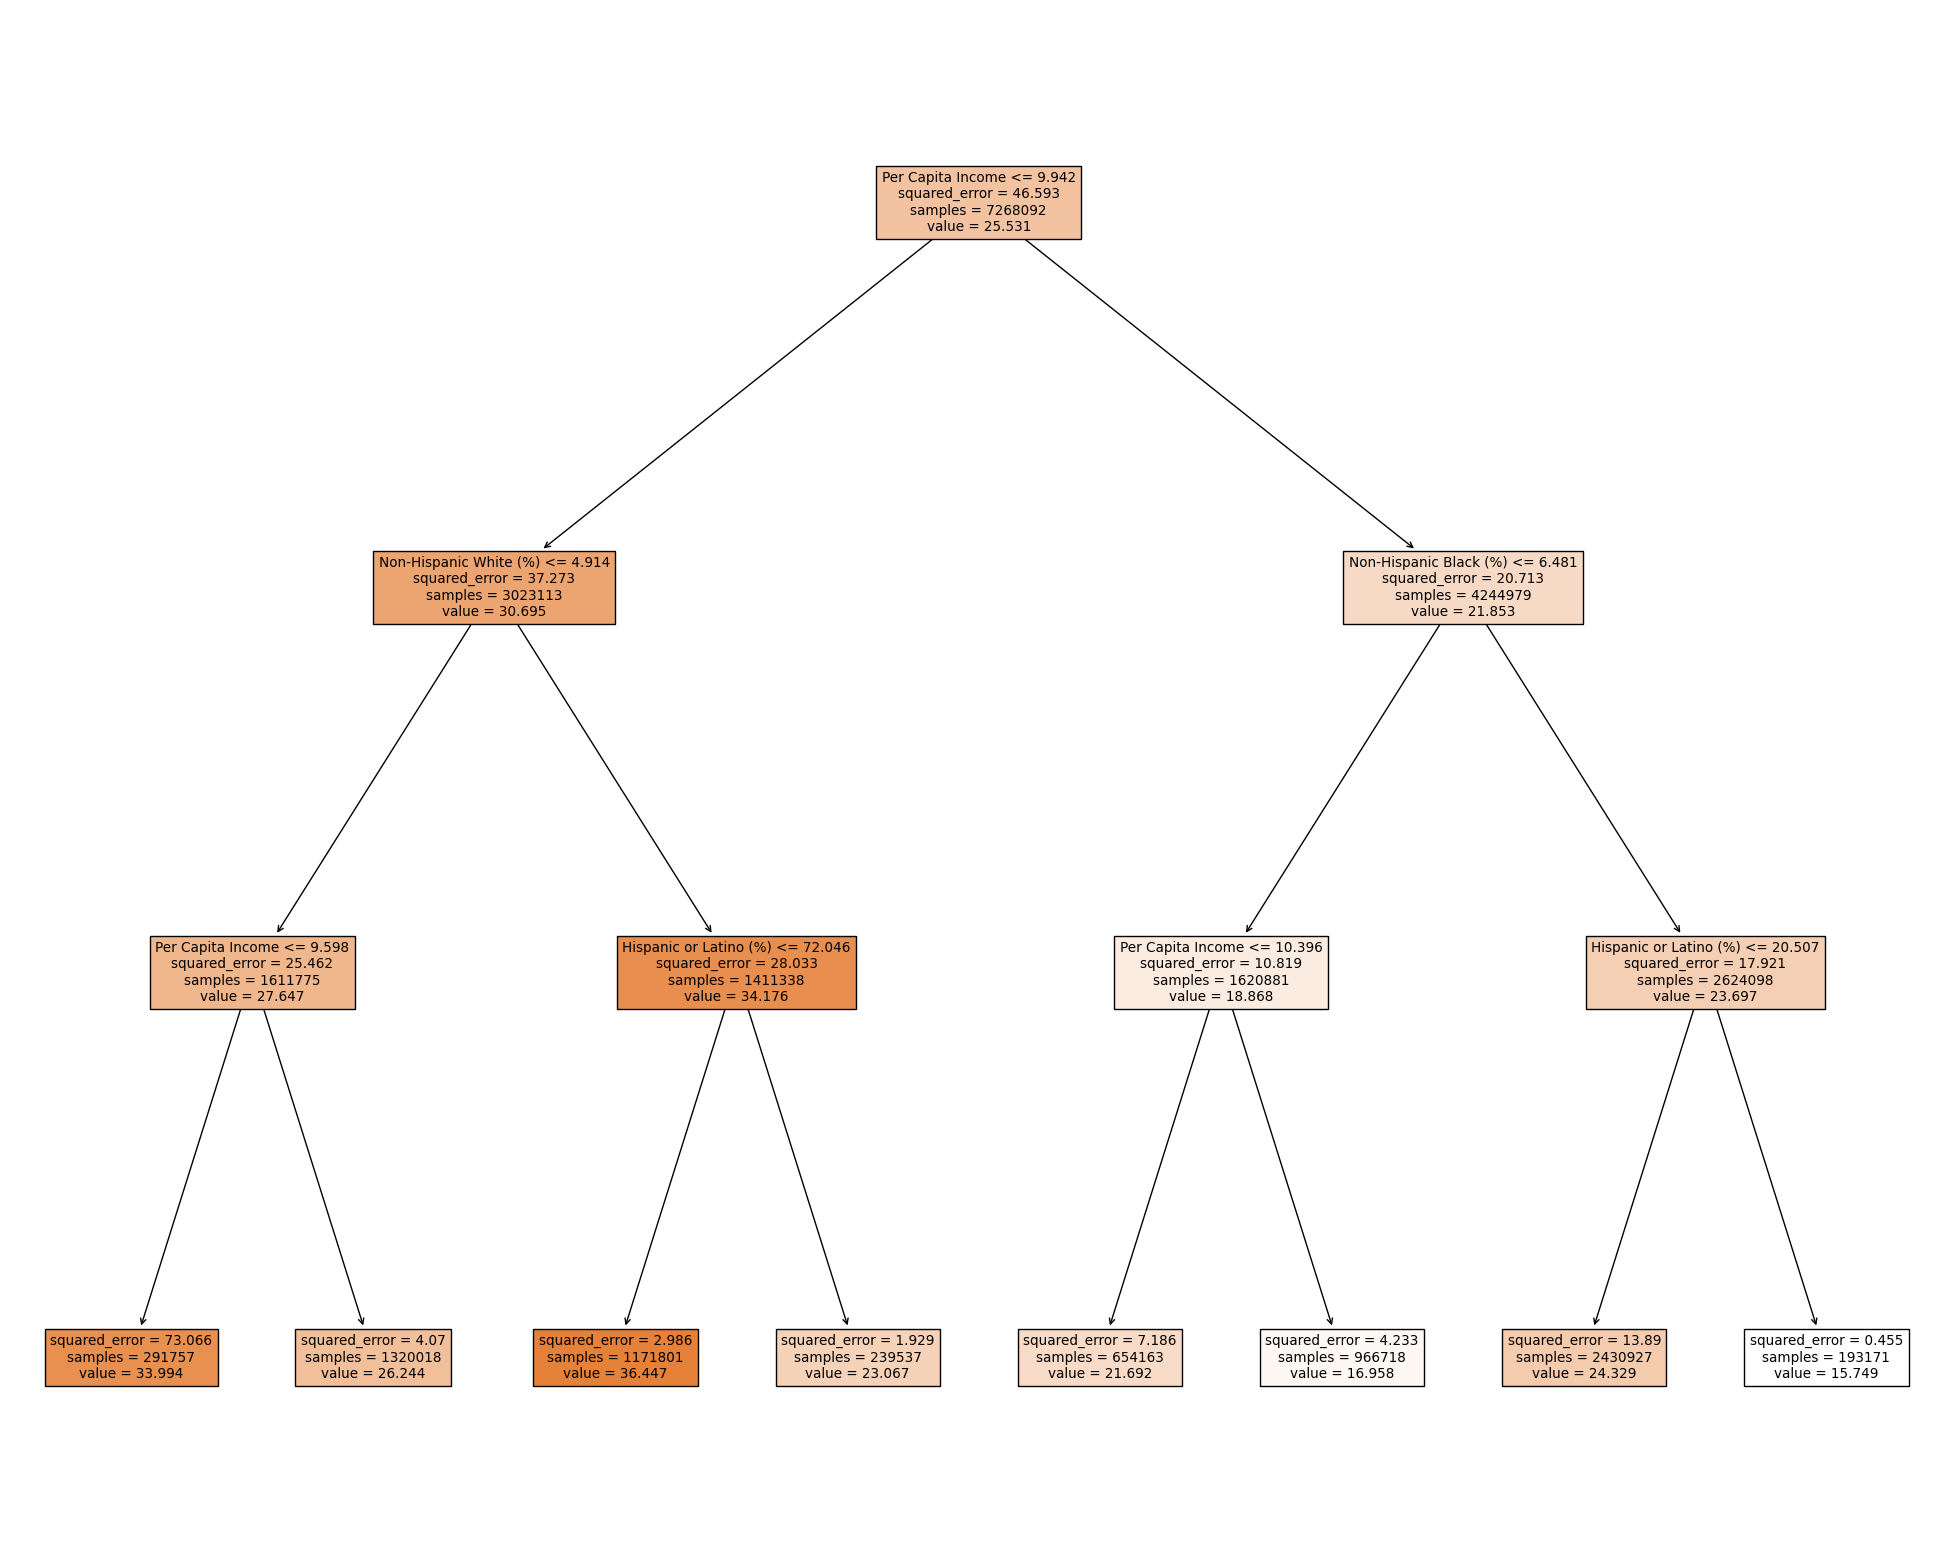

In [82]:
sqrf_fig = plt.figure(figsize=(25,20))
sqrf_fig = tree.plot_tree(reg_tree, feature_names=x.columns, filled=True)

The regression tree analysis insights into the relationship between per capita income, racial distribution, and arrest rates. The depth of the tree is 3, which is moderate, since deeper trees may capture more complex patterns in the data but can also lead to overfitting. The arrest rate across all data is about 25.5% and per capita income is the primary threshold that divides the data into two groups. We need to remember that instead of representing absolute income values, it now represents the logarithm of income. Areas with per capita income smaller than 9.942 have an arrest rate of 30.7%; on the other hand, those with per capita income greater than 9.942 have an arrest rate of 21.9%. Furthermore, the second layer of the tree is racial proportion, and then the third node contains per capita income again and other races. Those areas with whites less than 4.9% and per capita income less than 9.6 have an arrest rate of 34%, but it has a large squared error of 73.1, which might be due to the sample size being much smaller than others; while if whites greater than 4.9% and blacks greater than 12.1%, their arrest rates are 36.5%. The right branch of the tree shows when blacks in a community area are less than 6.5% and per capita income is lower than 10.4, the arrest rate will be 21.7%. However, if blacks are greater than 6.5% and Latinos are less than 20.5%, the arrest rate is 24.3%.

#### Prediction Error

In [42]:
pred_error = reg7.predict(dftree[x7])
mse = metrics.mean_squared_error(dftree['Arrest Rate (%)'], pred_error)
mse

28.29786270088694

In [43]:
mse_tree = metrics.mean_squared_error(dftree['Arrest Rate (%)'], reg_tree.predict(x))
mse_tree

10.08476048626682

In regression models, MSE represents the average squared difference between the observed and predicted values of the dependent variable. However, in regression tree models, MSE measures the variance of the target variable within each terminal node of the tree.

In this model, I calculated two MSEs for the regression and regression tree model which are 28.3 and 10.08, respectively. The 28.3 in regression model(reg7) indicates that, on average, the squared difference between the predicted arrest rates and the actual arrest rates is 28.3 units squared. Also, the 10.08 MSE value in the regression tree model suggests that, on average, the variance of the arrest rates within each leaf node of the tree is 10.08 units squared.

The lower MSE value for the regression tree model indicates that it captures more variability in the arrest rates within each leaf node compared to the regression model. Therefore, the regression tree model may provide better predictive performance for this dataset.

#### Regression Tree 2

In [49]:
df2 = df1.copy()
df2 = df2.drop(['ID', 'Case Number', 'Location', 'Arrest', 'Arrest Rate (%)', 'Community Area'], axis=1)
for col in list(df2):
    df2[col] = df2[col].astype(float)

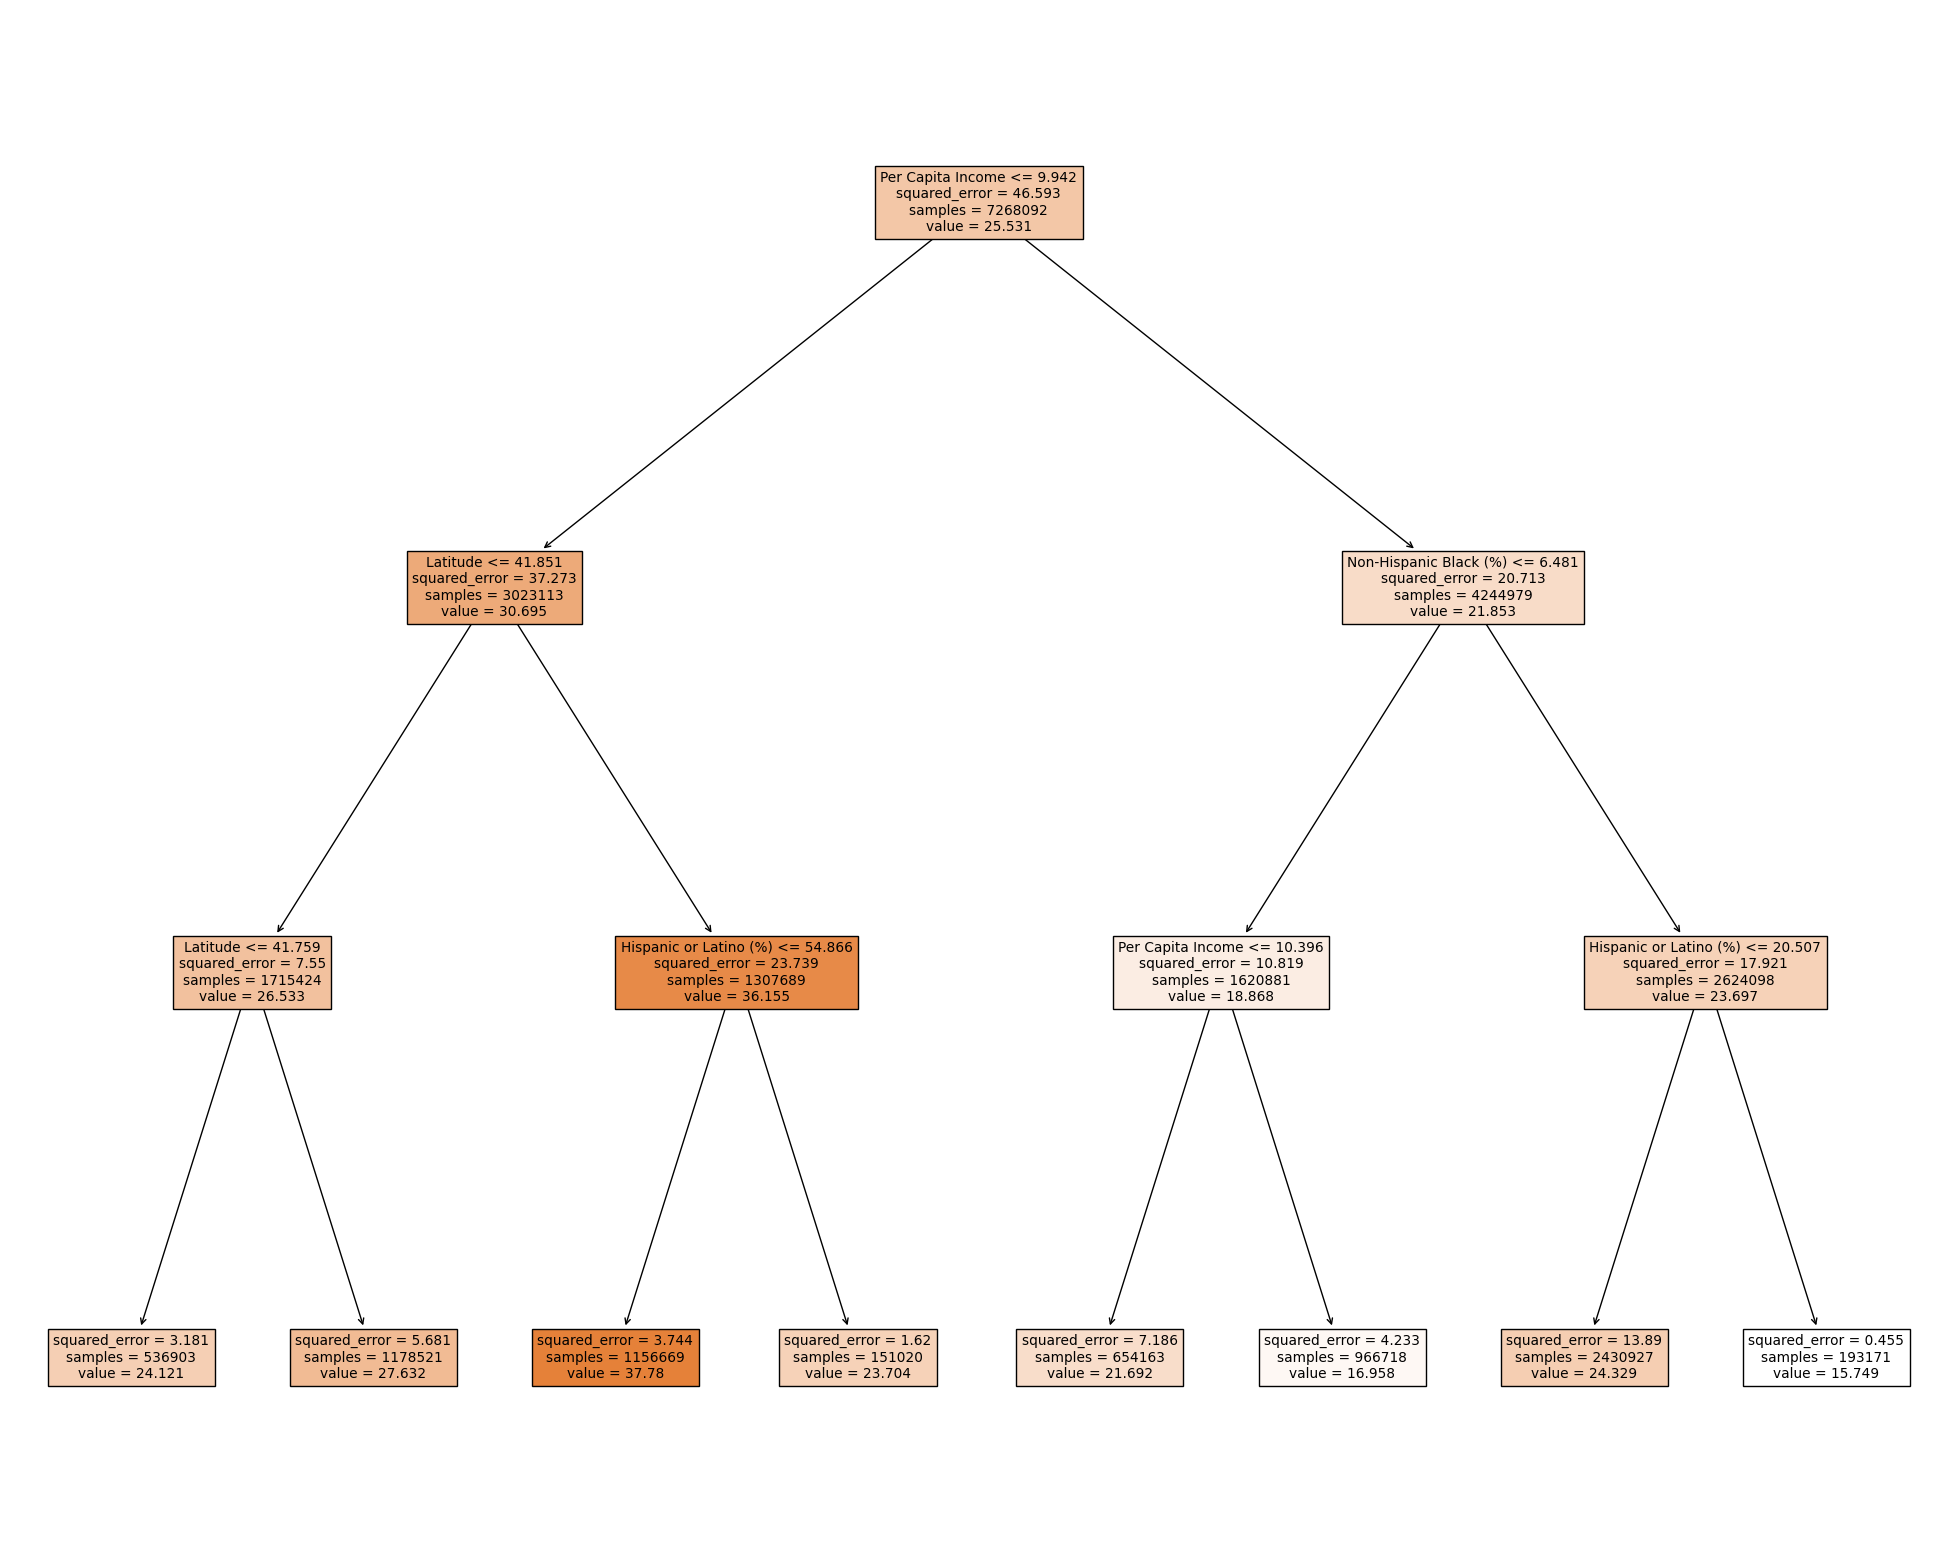

In [50]:
y2 = df1['Arrest Rate (%)']
reg_tree2 = tree.DecisionTreeRegressor(max_depth=3).fit(df2,y2)
sqrf_fig2 = plt.figure(figsize=(25,20))
sqrf_fig2 = tree.plot_tree(reg_tree2, feature_names=df2.columns, filled=True)

In [51]:
mse_tree2 = metrics.mean_squared_error(df1['Arrest Rate (%)'], reg_tree2.predict(df2))
mse_tree2

7.653226671965875

This regression tree contains all X variables and per capita income is still the most important variable that influences arrest rates. Compared to regression tree 1, this tree uses latitude instead of Non-Hispanic White (%) in the second layer to split data. Even though this tree has a lower MSE of 7.65, I do not think it is plausible since Chicago is not a very large city, so the latitude and longitude of each area are not very different. Also, using latitude and longitude to split data is actually due to the population, economy and other factors in each community area are different.

### 4.2.3 Random Forest Model

In [84]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

In [85]:
regr2 = RandomForestRegressor(max_features=5, random_state=1)
regr2.fit(x, y)
pred = regr2.predict(x)
mean_squared_error(y, pred)

8.303708767957073e-22

#### Importance Matrix

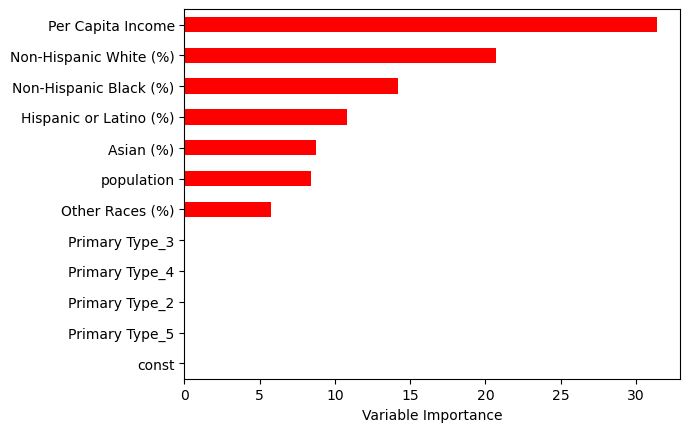

In [92]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=x.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [93]:
Importance.head()

Importance
const           0.000000e+00
Primary Type_2  1.755718e-07
Primary Type_3  4.120234e-03
Primary Type_4  7.296912e-04
Primary Type_5  8.913222e-10

Here, I create an importance matrix, which shows how important the X variable is. This importance is calculated based on how much each feature decreases the impurity of the nodes in the decision trees within the forest. As we can see, per capita income is the most important indicator across all variables, then it is followed by the percentage of whites and blacks. They are consistent with the regression tree before. Here is what we need to note in the important matrix plot, each primary type does not show up, but it does not mean their importance is 0. From the 'Importance' data frame we could know that they are still important, but very small.

### 4.2.4 Comparison Between OLS Model and Regression Tree

Both OLS regression and regression tree have valuable information for analyzing between dependent and independent variables. After running those two regressions, I found that OLS regression is suitable for analyzing linear relationships, or when the relationship between the variables is well understood and the linearity hypothesis holds. However, when the relationship is not linear and has complex interactions, it is useful to use a regression tree.

From the regression table above, we can easily know the effect of a single predictor on the dependent variable and determine whether the independent variable has a positive or negative effect on the dependent variable. The coefficient of per capita income in OLS regression is negative, which causes an illusion that richer area has a lower arrest rate. However, the regression tree gives a critical value and divides per capita income into two groups first to get a more specific result. This shows regression trees can capture nonlinear relationships between predictor and target variables.

Moreover, the regression tree connects other important independent variables. In my tree, the arrest rate mainly depends on the value of per capita income and each racial proportion, so it does not just depend on one variable; and this is what we cannot see in the OLS regression model. Also, it tells me per capita income has the most influence on the arrest rate so that I can prioritize this variable for further analysis.

## 5. Coclusion and Future Work

### Conclusion

Overall, this project is trying to analyze how crime types and demographic and economic factors influence arrest rates in different community areas of Chicago from 2002 to 2023. According to statistical and visual analysis in the first three projects, also incorporating OLS regression and regression trees in the final project, they provide evidence that economic factors and racial distribution have a strong influence on arrest rates in each community area in Chicago. 

With our analysis in Project 1, we see that over time, the number of crimes went down year by year and the arrest rate went down year by year. In addition, from the end analysis, we know that in 39 out of 77 regions, the most frequent type of crime was theft, but with our initial exploration, the number of people who were not arrested for theft was also the highest, even though it does not have the lowest arrest rate. Also, we found that the number of types of crime in an area affects the arrest rate in that area. Based on crime types, years, and community areas, the arrest rate has a large range with a minimum of 0% and a maximum of 100%. The average arrest rate is only around 19.3%, which implies in a significant portion of the data, arrests were made for approximately 19.3% of reported incidents. This indicates considerable variability in law enforcement outcomes across different crime types, years, and community areas.

Project 2 shows the relationship between some variables and Chicago community areas by merging a per capita income new dataset and creating maps. There are several areas in the upper middle West with higher arrest rates. Also, the north side of Chicago has lower arrest rates than the south side of Chicago. In addition, the map of the difference in the number of crimes per 100k per area represents that crime counts and arrest rates have a positive correlation; and the number of non-violent crimes is greater than the number of violent overall. Lastly, the map of per capita income in each community area suggests that several areas on the upper right of Chicago have the highest per capita incomes, while the west and south sides have relatively low incomes.

To have a deeper understanding, by scrapping the average temperature data and plotting, the line chart and bar plot shows a positive correlation between crime and temperature, where July with the highest temperature has the highest number of crimes and February with the lowest temperature has the lowest. However, the arrest rates seem a negative relationship with temperature. On the contrary, February has the highest arrest rate, while July has the lowest. Furthermore, by merging racial distribution for each community area into the data frame, it shows that whites, blacks and Latinos are the three main races in Chicago. Then, combined with Project 2, the areas with high arrest rates and low per capita incomes are mostly black and a small number predominantly Latino.

Finally, running OLS regressions and regression trees helps us observe the extent to which each independent variable influences the arrest rate and their interaction better. In the OLS regressions part, the coefficients of each variable show per capita income and population are two variables that have a large impact on arrest rates. Also, compared to violent crimes, the number of drug-related crimes occurring affects the arrest rate even more. Moreover, by running regression trees and an importance matrix, they suggest that per capita income is the most important variable, and then is the proportion of whites and blacks in each community area.

In conclusion, the data highlights the complexity and diversity of arrest outcomes in the context of crime types, years, and community areas. It becomes evident that arrest outcomes are influenced by a multitude of interconnected factors, including but not limited to crime types, temporal trends, socio-economic conditions, and racial demographics. This analysis of different datasets provides evidence of arrest rates, primarily influenced by economic factors, such as per capita income, and racial distribution also makes a difference in arrest rates. Therefore, improving community resources or policing practices, reducing racial discrimination, and monitoring each other are crucial to creating a safe community.

### Limitation and Future Work

While this study provides valuable insights, it is important to acknowledge limitations. In this project, we only consider per capita income, population, and racial distribution to explain why each community area has different arrest rates and how they influence them. But there are many other variables that we did not consider, for instance, age, gender, and community policing strategy. Also, in the regression part, even though we got some correlations and results between variables and arrest rates, the model does not fit the actual value very well since we only use logarithmic and linear functions, they would be more complex and flexible in the real world. In addition, this research is only based on 2002 to 2023 in Chicago, it is valuable to analyze other countries and a longer time. It is difficult to include an arrest policy in this project, so there might exist biases, and need more research.

In future work, it is suggested to include other variables, perform a more refined analysis and consider longitudinal studies. For those years with significant differences, it is better to study what happened in those years, for example, there was a recession in that year, which caused the arrest rate lower. Additionally, future research could use more complex models to fit the actual situation better.

## References

1. Braga, A. A., Hureau, D. M., & Papachristos, A. V. (2011). The Relevance of Micro Places to Citywide Robbery Trends: A Longitudinal Analysis of Robbery Incidents at Street Corners and Block Faces in Boston. Journal of Research in Crime and Delinquency, 48(1), 7-32. https://doi.org/10.1177/0022427810384137

2. Erbe, B. M. (1975). Race and Socioeconomic Segregation. American Sociological Review, 40(6), 801–812. https://doi.org/10.2307/2094181

3. Hou, K., Zhang, L., Xu, X., Yang, F., Chen, B., Hu, W., & Shu, R. (2023). High ambient temperatures are associated with urban crime risk in Chicago. Science of The Total Environment, 856(1), 158846. https://doi.org/10.1016/j.scitotenv.2022.158846

4. Ousey, Graham C. (2000). “Explaining Regional and Urban Variation in Crime: A Review of Research.” Office of Justice Programs, https://www.ojp.gov/library/publications/explaining-regional-and-urban-variation-crime-review-research.

5. Schleiden, C., Soloski, K. L., Milstead, K., & Rhynehart, A. (2020). Racial disparities in arrests:  A Race Specific Model Explaining Arrest Rates Across Black and White Young Adults. Child Adolesc Soc Work Journal, 37, 1–14. https://link.springer.com/article/10.1007/s10560-019-00618-7#Abs1 

6. Wilson, W. J. (1987). The truly disadvantaged: The inner city, the underclass, and public policy. University of Chicago Press.